In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from xgboost import cv as xgb_cv, DMatrix
from catboost import cv as catboost_cv

from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import make_scorer

from itertools import product
import copy

import warnings
warnings.filterwarnings('ignore')
import time 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [63]:
# Download latest version
path_train = "train.csv"
path_test = "test.csv"

# Exploració de les dades


Aquest conjunt de dades inclou descripcions de mostres hipotètiques corresponents a 23 espècies de bolets branquials del bolet de la família Agaricus i Lepiota extretes de The Audubon Society Field Guide to North American Mushrooms. Cada espècie s'identifica com a definitivament comestible, definitivament verinosa o de comestibilitat desconeguda i no recomanada. Aquesta darrera classe es va combinar amb la verinosa.

La Guia diu clarament que no hi ha una regla senzilla per determinar la comestibilitat d'un bolet, per tant, intentarem trobar el millor model que pugui classificar els bolets en comestibles o no comestibles a partir de les seves característiques.

In [64]:
# Load CSV file into DataFrame
train_orig = pd.read_csv(path_train)
df = train_orig.copy()
df_test = pd.read_csv(path_test)

df = df.sample(frac=0.1, random_state=42)
df = df.reset_index(drop=True)


del train_orig


Com que treballem amb més de 3.000.000 de dades, agafarem una partició del 10% del dataset original.

In [65]:
df_test_ids = pd.read_csv(path_test)
df_test_ids = df_test_ids['id']

In [66]:
df_test_ids

0          3116945
1          3116946
2          3116947
3          3116948
4          3116949
            ...   
2077959    5194904
2077960    5194905
2077961    5194906
2077962    5194907
2077963    5194908
Name: id, Length: 2077964, dtype: int64

l primer que farem sera eliminar la columna ID, la qual no ens aportara cap informació útil, ja que només és un valor incremental diferent per a cada fila, no dona informació del bolet.

In [67]:
df = df.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [68]:
print(df.shape)
print(df.dtypes)

(311694, 21)
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object


A primera vista, tenim un dataset amb 3116945 exemplars pel train i 20 característiques.

Característiques nominals:

* class: classe (per exemple, comestible o tòxica)
* cap-shape: forma del barret
* cap-surface: superfície del barret
* cap-color: color del barret
* does-bruise-or-bleed: presència de marques/morellia o sagnat
* gill-attachment: adhesió de les làmines
* gill-color: color de les làmines
* stem-root: tipus de base del peu
* ring-type: tipus d'anell
* stem-surface: superfície del peu
* stem-color: color del peu
* veil-type: tipus de vel
* veil-color: color del vel
* gill-spacing: espaiament de les làmines
* has-ring: presència d'anell
* spore-print-color: color de l'empremta de les espores
* habitat: hàbitat
* season: estació de l'any

Característiques quantitatives (numèriques):

* cap-diameter: diàmetre del barret
* stem-height: alçada del peu
* stem-width: amplada del peu


Necesitem també calcular la quantitat de NaNs que conte el nostre dataset, i més endevant haurem de decidir com tractar-los per obtenir els millors resultats. Ja sigui eliminar tota fila amb NaNs, la columna sencera si té un alt percentatge o reomplir els valors amb alguna tecnica com la mitja en cas de valors

In [69]:
print(f"NaNs al dataset: ", df.isna().sum().sum())

NaNs al dataset:  1587148


Aquest dataset conte molts NaNs, més endevant sera necesari tractar amb ells d'alguna manera per poder millorar els resultats.

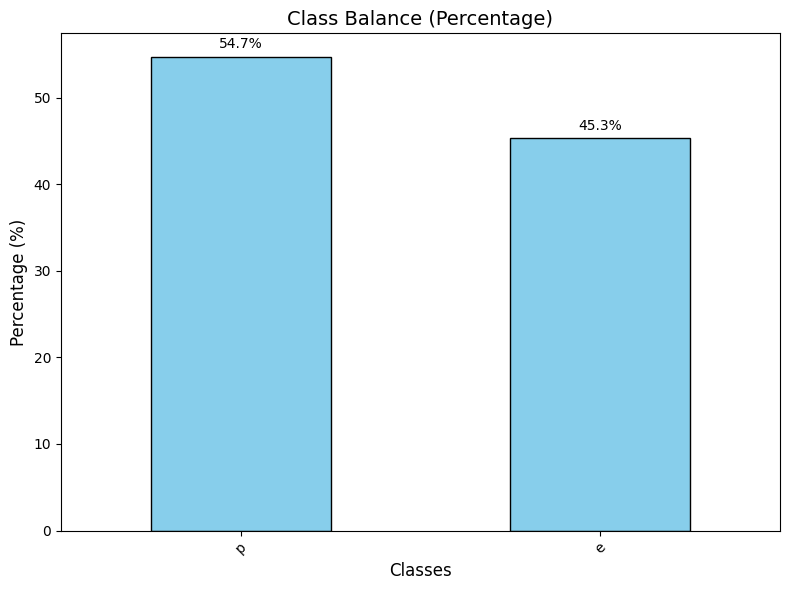

In [93]:
class_percentages = df['class'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
bars = class_percentages.plot(kind='bar', color='skyblue', edgecolor='black')

for i, percentage in enumerate(class_percentages):
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=10)
plt.title('Class Balance (Percentage)', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
plt.close()

El 'target' està força balancejat, per tant, podrem utilitzar mètriques com l'accuracy per evaluar els nostres models.

Per seguir explorant les dades comprobarem com estan distribuits els atributs en cada classe i quins són els diferents valors que contenen.

In [71]:
object_columns = [col for col in df.columns if df[col].dtype == 'object']
numeric_columns = [col for col in df.columns if df[col].dtype == 'float64']

for column in object_columns:
    print(column)
    print(df[column].unique())


class
['p' 'e']
cap-shape
['s' 'o' 'f' 'b' 'x' 'c' 'p' 'd' 'b f' 'n' 'e' 'w' nan '19.06' '5.15'
 '7.21' 'a' 'k' 'r' '4.22' 't' '6.44' 'i' 'g' 'y' 'u' 'l' 'ring-type'
 '8.3' 'z']
cap-surface
['t' nan 'd' 'h' 's' 'y' 'k' 'g' 'e' 'w' 'i' 'l' 'a' 'p' '5.07' 'n' 'u'
 'o' 'r' 'b' 'f' 'c' '2.7' '1.43' 'x' 'm' '3.06' '41.91' 'season' '7.99']
cap-color
['r' 'g' 'n' 'e' 'u' 'p' 'y' 'o' 'w' 'k' 'b' 'l' 's' 't' '8.67' 'z' 'm'
 '6.9' 'f' 'a' nan 'x' 'ring-type' '5.91' 'd' 'h' 'c' '8.57']
does-bruise-or-bleed
['t' 'f' 'w' nan 'x' 'y' 'h']
gill-attachment
['d' 'f' nan 'x' 's' 'e' 'a' 'p' 'z' 'b' 'w' 'l' 'y' 'n' 'i' '7.92' 'u'
 '4.77' 'k' 't' 'g' 'o' 'does' 'season' '1.48' 'c']
gill-spacing
[nan 'f' 'c' 'd' 'e' 'x' 't' 's' '6.67' 'b' 'l' 'class' '1' 'a']
gill-color
['g' 'f' 'w' 'n' 'p' 'y' 'o' 'k' 'e' 'b' 'r' 'u' 'spacing' 'i' 't' '5' 's'
 nan 'a' 'x' 'd' '20.6' 'season' 'l' 'h' '4.64' 'ring-type' '7.59' 'z' 'c']
stem-root
[nan 'b' 's' 'r' 'c' 'f' 't' '3.49' '20.01' 'w' 'y' 'k' 'e' 'g' 'o' 'x'
 'l' 'p

In [72]:
df.nunique()

class                      2
cap-diameter            2863
cap-shape                 29
cap-surface               29
cap-color                 27
does-bruise-or-bleed       6
gill-attachment           25
gill-spacing              13
gill-color                29
stem-height             2238
stem-width              4530
stem-root                 18
stem-surface              23
stem-color                24
veil-type                  7
veil-color                13
has-ring                  11
ring-type                 20
spore-print-color         17
habitat                   22
season                     4
dtype: int64

Aquest dataset sembla estar molt brut, tenim molts valors anòmals en les variables categòriques amb valors que no tenen sentit generant una quantitat molt gran de classes, per exemple en la categoria 'habitat' tenim com a atributs els valors 8.09, 9.28, 'does-bruise-or-bleed', etc. Totes les característiques categòriques sembla que segueixen el mateix patró. Eliminarem els valors que siguin numèrics o que no tinguin sentit, per fer-ho, ens quedarem només amb classes que continguin 1 lletra.

In [73]:
def clean_dataset(df):
    filtered_df = df
    for col in object_columns:
      if col in filtered_df.columns:
        filtered_df[col] = filtered_df[col].where(filtered_df[col].astype(str).str.match(r'^[a-zA-Z]$'))
    for column in object_columns:
        print(column)
        print(filtered_df[column].unique())
    """
    for col in object_columns:
      if col in df_test.columns:
        df_test[col] = df_test[col].where(df_test[col].astype(str).str.match(r'^[a-zA-Z]$'))
    """
    return filtered_df
filtered_df = clean_dataset(df)

class
['p' 'e']
cap-shape
['s' 'o' 'f' 'b' 'x' 'c' 'p' 'd' nan 'n' 'e' 'w' 'a' 'k' 'r' 't' 'i' 'g'
 'y' 'u' 'l' 'z']
cap-surface
['t' nan 'd' 'h' 's' 'y' 'k' 'g' 'e' 'w' 'i' 'l' 'a' 'p' 'n' 'u' 'o' 'r'
 'b' 'f' 'c' 'x' 'm']
cap-color
['r' 'g' 'n' 'e' 'u' 'p' 'y' 'o' 'w' 'k' 'b' 'l' 's' 't' nan 'z' 'm' 'f'
 'a' 'x' 'd' 'h' 'c']
does-bruise-or-bleed
['t' 'f' 'w' nan 'x' 'y' 'h']
gill-attachment
['d' 'f' nan 'x' 's' 'e' 'a' 'p' 'z' 'b' 'w' 'l' 'y' 'n' 'i' 'u' 'k' 't'
 'g' 'o' 'c']
gill-spacing
[nan 'f' 'c' 'd' 'e' 'x' 't' 's' 'b' 'l' 'a']
gill-color
['g' 'f' 'w' 'n' 'p' 'y' 'o' 'k' 'e' 'b' 'r' 'u' nan 'i' 't' 's' 'a' 'x'
 'd' 'l' 'h' 'z' 'c']
stem-root
[nan 'b' 's' 'r' 'c' 'f' 't' 'w' 'y' 'k' 'e' 'g' 'o' 'x' 'l' 'p' 'a']
stem-surface
['t' 'g' nan 's' 'y' 'i' 'k' 'h' 'f' 'p' 'a' 'l' 'r' 'm' 'b' 'd' 'w' 'u'
 'o' 'c' 'x' 'e']
stem-color
['g' 'n' 'w' 'e' 'r' 'y' 'o' 'k' 'u' 'p' 'l' 'b' 'f' 'a' 'z' 's' nan 't'
 'x' 'i' 'm' 'd' 'h']
veil-type
[nan 'u' 'g' 'w' 'e' 'a' 'c' 'f']
veil-color
[nan 'w

In [74]:
filtered_df.nunique()

class                      2
cap-diameter            2863
cap-shape                 21
cap-surface               22
cap-color                 22
does-bruise-or-bleed       6
gill-attachment           20
gill-spacing              10
gill-color                22
stem-height             2238
stem-width              4530
stem-root                 16
stem-surface              21
stem-color                22
veil-type                  7
veil-color                12
has-ring                  11
ring-type                 20
spore-print-color         16
habitat                   19
season                     4
dtype: int64

Despres de passar aquest filtre veiem com s'han reduït molt el nombre de classes diferents en cada caracteristica, a excepció de les caracteristiques numeriques "cap-diameter", "stem-height" i "stem-width".

# Anàlisis de variables categòriques (nominals i ordinals)

Una part molt important en el analisis de dades es saber com estan distribuides les dades en el nostre dataset, que la caracterisitica a analitzar estigui o no balancejada farà que alguns models funcionin millor o pitjor.

Farem també un analisi de totes les caracteristiques despres del filtre per veure si estan molt descompensades, per saber si s'utilitzen totes les classes o només s'usen dues i la resta nomes estan repetides unes poques vegades.


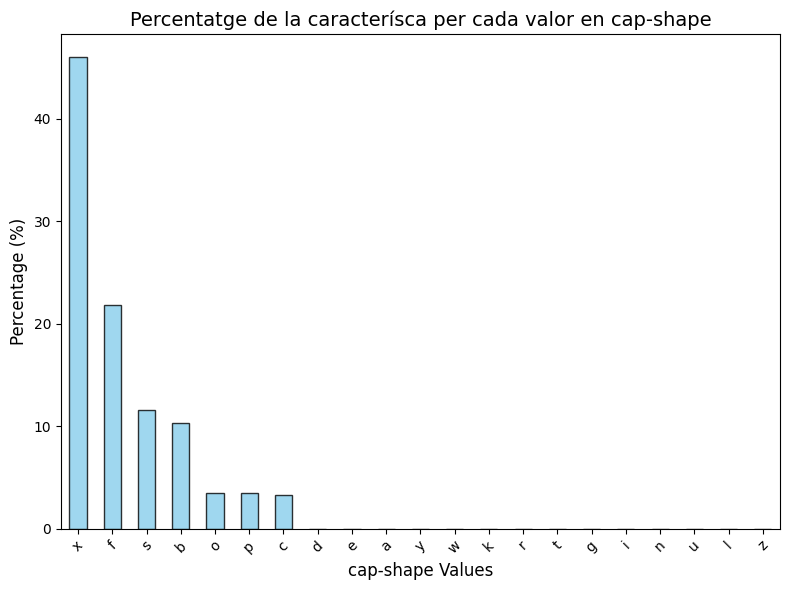

cap-shape
x   45.9863
f   21.8235
s   11.6308
b   10.2771
o    3.4821
p    3.4513
c    3.3371
d    0.0029
e    0.0019
a    0.0010
y    0.0010
w    0.0010
k    0.0006
r    0.0006
t    0.0006
g    0.0006
i    0.0003
n    0.0003
u    0.0003
l    0.0003
z    0.0003
Name: proportion, dtype: float64



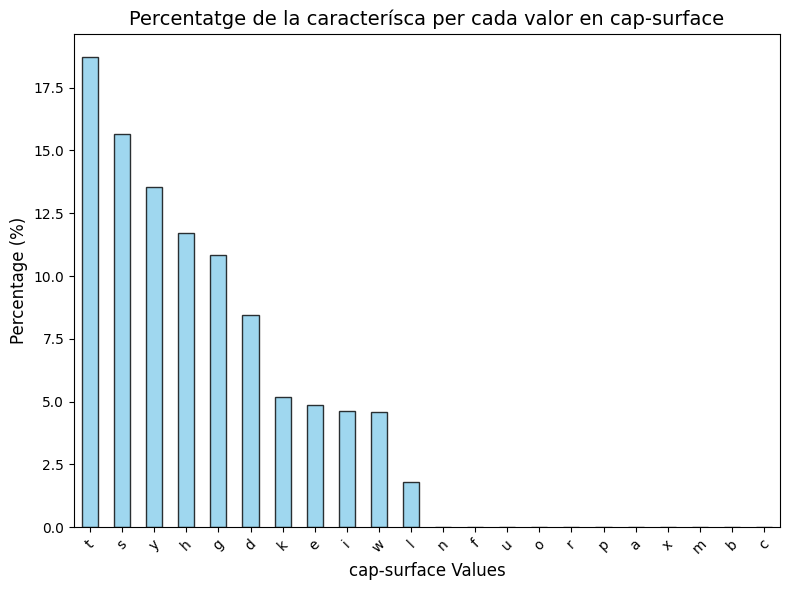

cap-surface
t   18.7076
s   15.6658
y   13.5266
h   11.7301
g   10.8305
d    8.4576
k    5.1949
e    4.8762
i    4.6144
w    4.5706
l    1.8062
n    0.0037
f    0.0033
u    0.0029
o    0.0020
r    0.0020
p    0.0016
a    0.0012
x    0.0008
m    0.0008
b    0.0004
c    0.0004
Name: proportion, dtype: float64



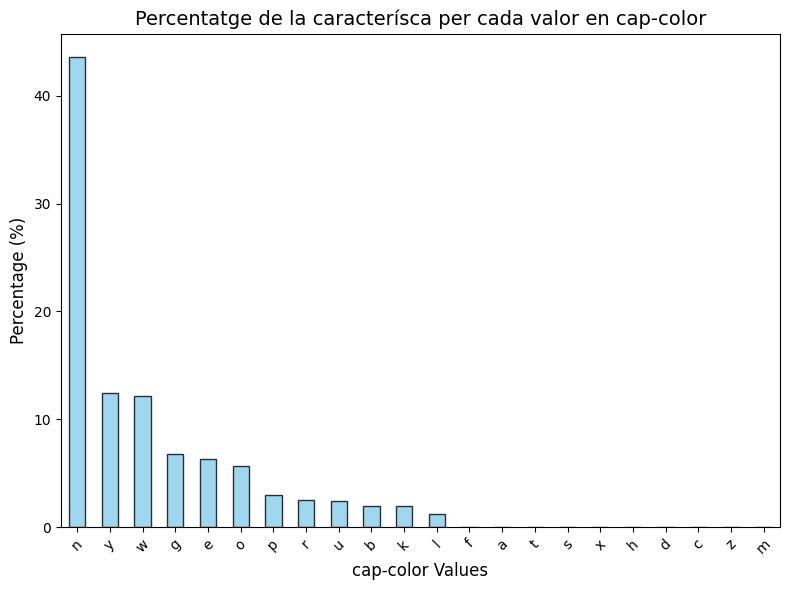

cap-color
n   43.5455
y   12.4073
w   12.1859
g    6.8001
e    6.3063
o    5.6836
p    2.9555
r    2.5372
u    2.3931
b    2.0033
k    1.9494
l    1.2221
f    0.0022
a    0.0019
t    0.0016
s    0.0013
x    0.0010
h    0.0010
d    0.0006
c    0.0006
z    0.0003
m    0.0003
Name: proportion, dtype: float64



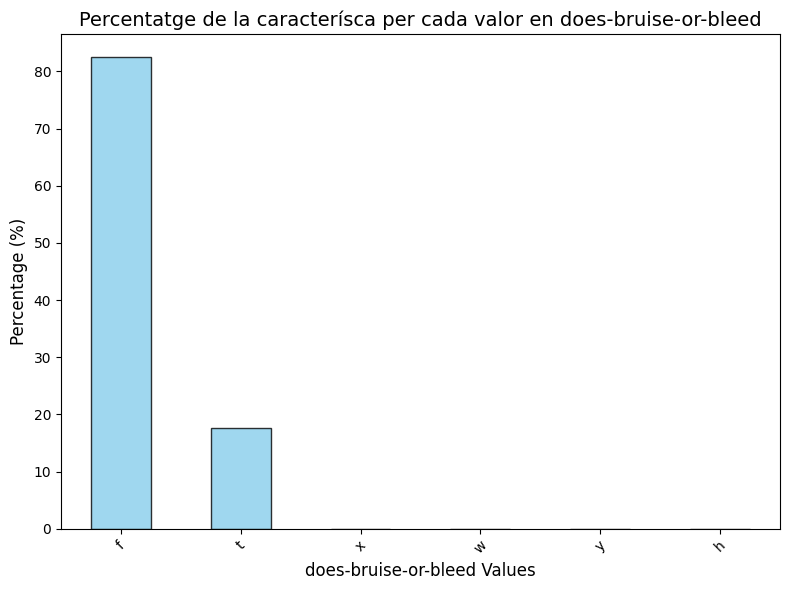

does-bruise-or-bleed
f   82.4414
t   17.5570
x    0.0006
w    0.0003
y    0.0003
h    0.0003
Name: proportion, dtype: float64



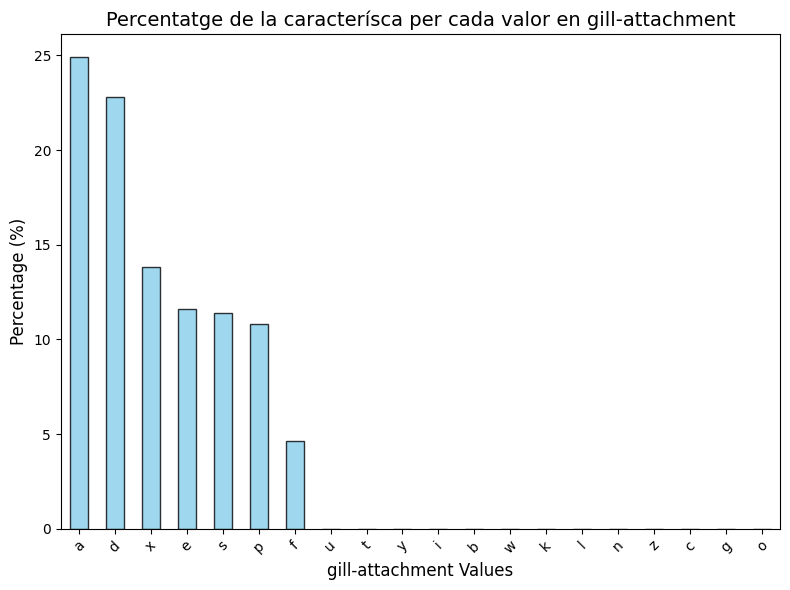

gill-attachment
a   24.8961
d   22.7921
x   13.8502
e   11.5957
s   11.4128
p   10.8194
f    4.6185
u    0.0023
t    0.0023
y    0.0015
i    0.0015
b    0.0012
w    0.0012
k    0.0012
l    0.0008
n    0.0008
z    0.0008
c    0.0008
g    0.0004
o    0.0004
Name: proportion, dtype: float64



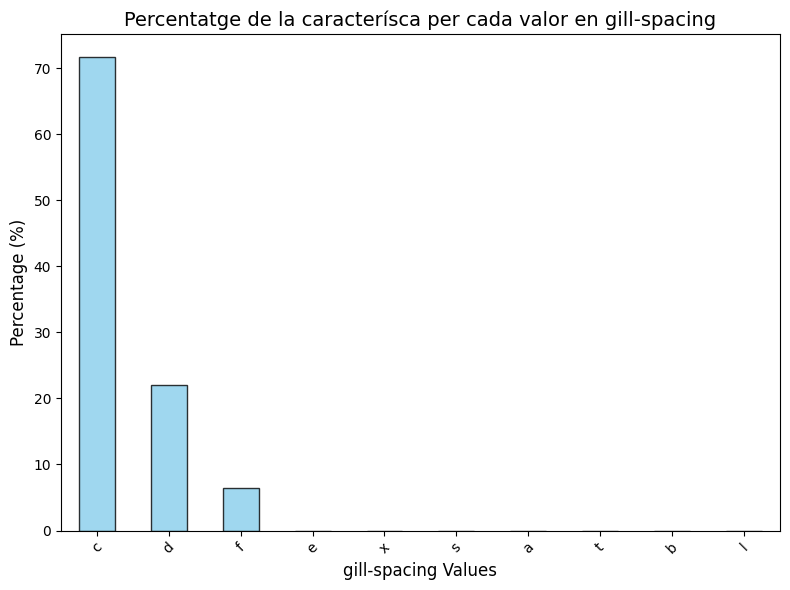

gill-spacing
c   71.5923
d   21.9891
f    6.4121
e    0.0016
x    0.0011
s    0.0011
a    0.0011
t    0.0005
b    0.0005
l    0.0005
Name: proportion, dtype: float64



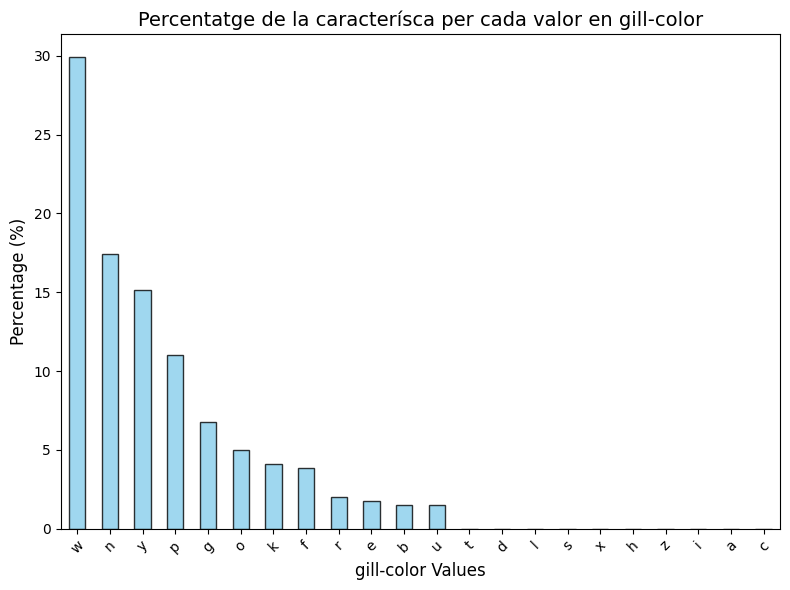

gill-color
w   29.8994
n   17.4491
y   15.1486
p   10.9937
g    6.7634
o    4.9962
k    4.1360
f    3.8331
r    2.0050
e    1.7512
b    1.5307
u    1.4845
t    0.0016
d    0.0016
l    0.0013
s    0.0010
x    0.0010
h    0.0010
z    0.0006
i    0.0003
a    0.0003
c    0.0003
Name: proportion, dtype: float64



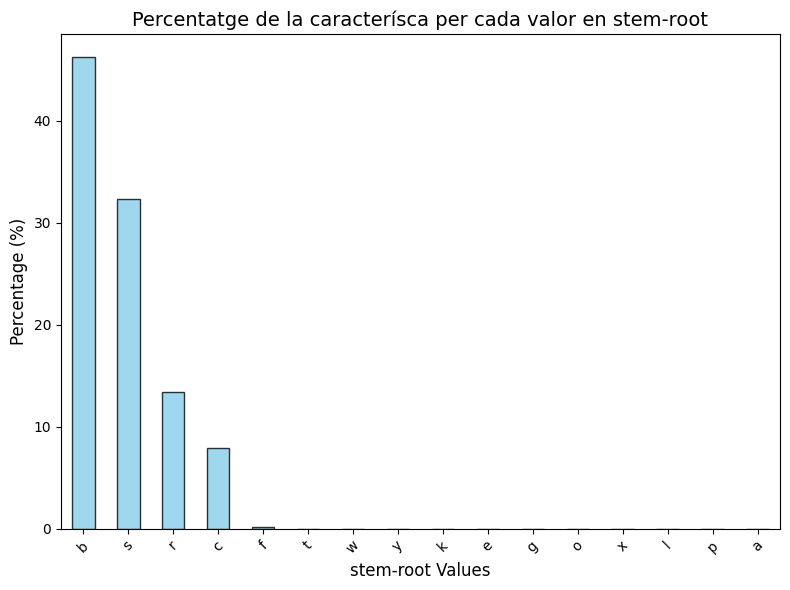

stem-root
b   46.1863
s   32.3537
r   13.3640
c    7.8992
f    0.1553
t    0.0055
w    0.0055
y    0.0055
k    0.0055
e    0.0028
g    0.0028
o    0.0028
x    0.0028
l    0.0028
p    0.0028
a    0.0028
Name: proportion, dtype: float64



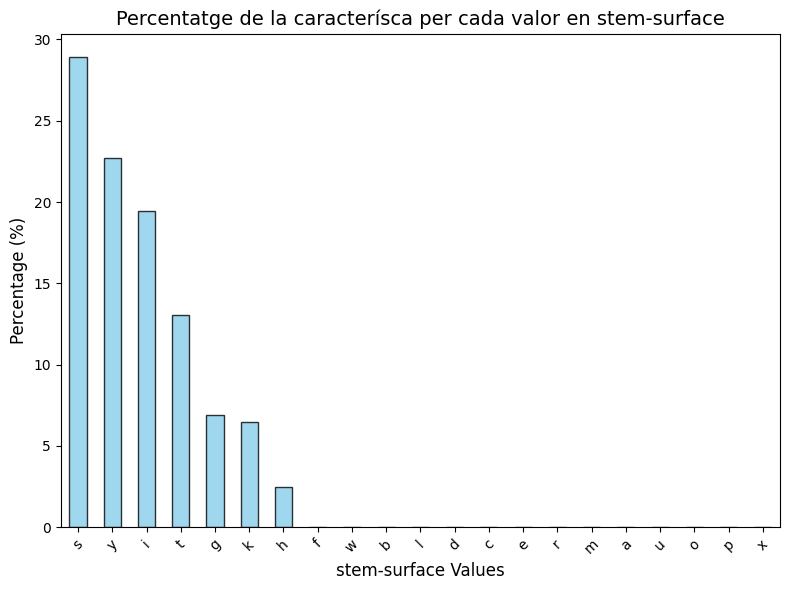

stem-surface
s   28.9002
y   22.7159
i   19.4618
t   13.0259
g    6.8988
k    6.4641
h    2.4612
f    0.0422
w    0.0044
b    0.0035
l    0.0035
d    0.0026
c    0.0026
e    0.0026
r    0.0018
m    0.0018
a    0.0018
u    0.0018
o    0.0018
p    0.0009
x    0.0009
Name: proportion, dtype: float64



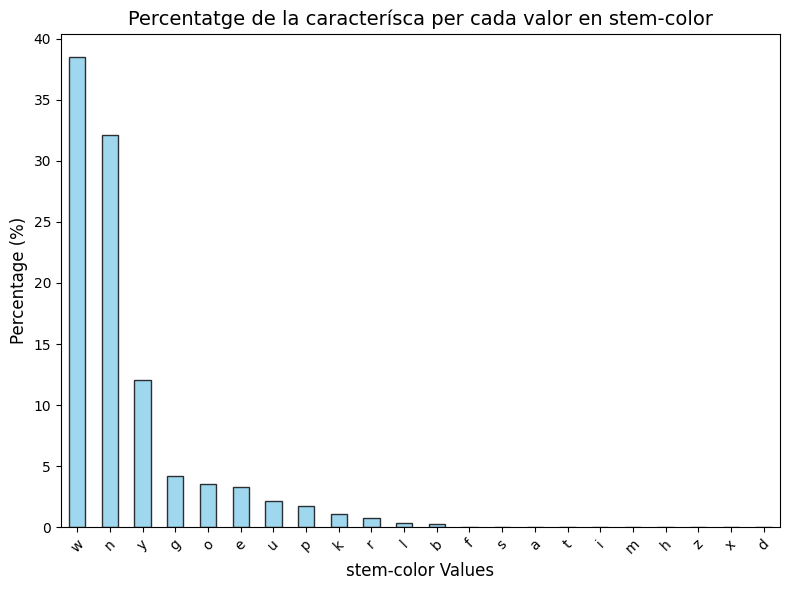

stem-color
w   38.4626
n   32.1390
y   12.0158
g    4.2010
o    3.5404
e    3.3219
u    2.1634
p    1.7668
k    1.0790
r    0.7199
l    0.3266
b    0.2393
f    0.0170
s    0.0019
a    0.0013
t    0.0013
i    0.0006
m    0.0006
h    0.0006
z    0.0003
x    0.0003
d    0.0003
Name: proportion, dtype: float64



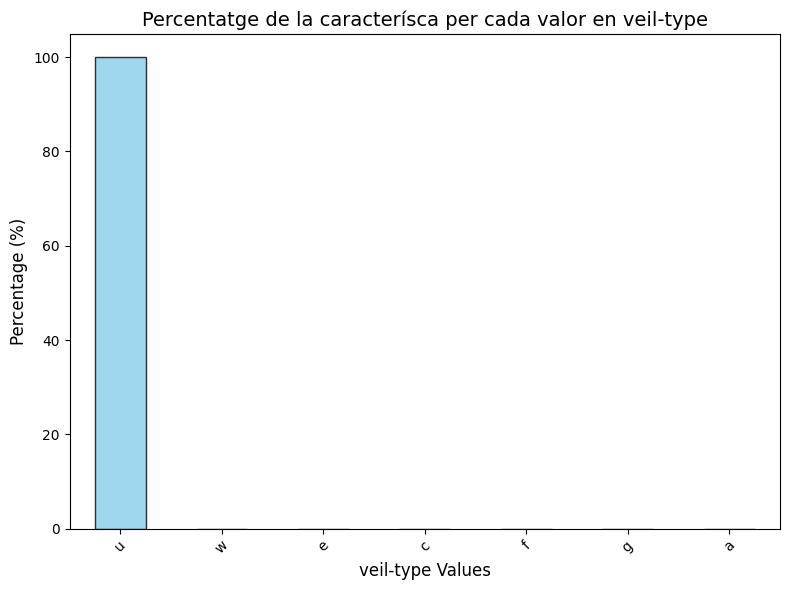

veil-type
u   99.9375
w    0.0125
e    0.0125
c    0.0125
f    0.0125
g    0.0062
a    0.0062
Name: proportion, dtype: float64



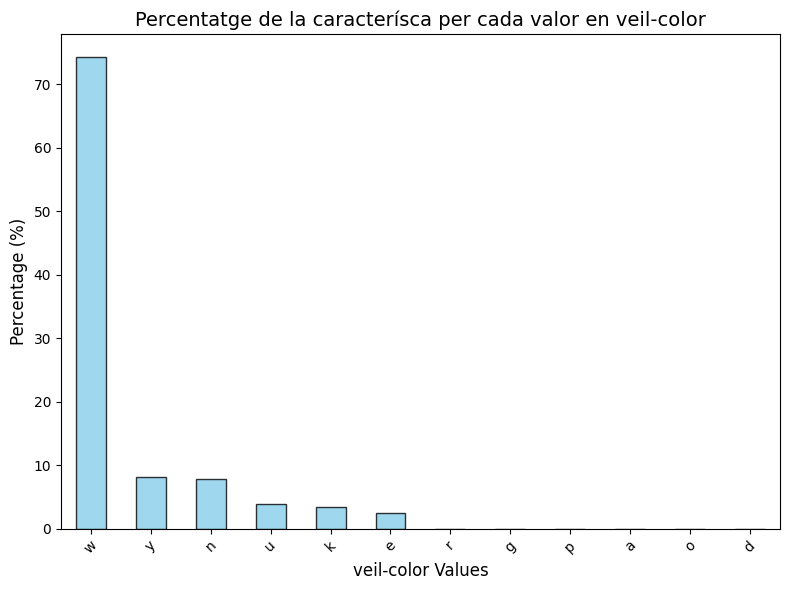

veil-color
w   74.2363
y    8.1164
n    7.8509
u    3.8618
k    3.4398
e    2.4604
r    0.0106
g    0.0080
p    0.0080
a    0.0027
o    0.0027
d    0.0027
Name: proportion, dtype: float64



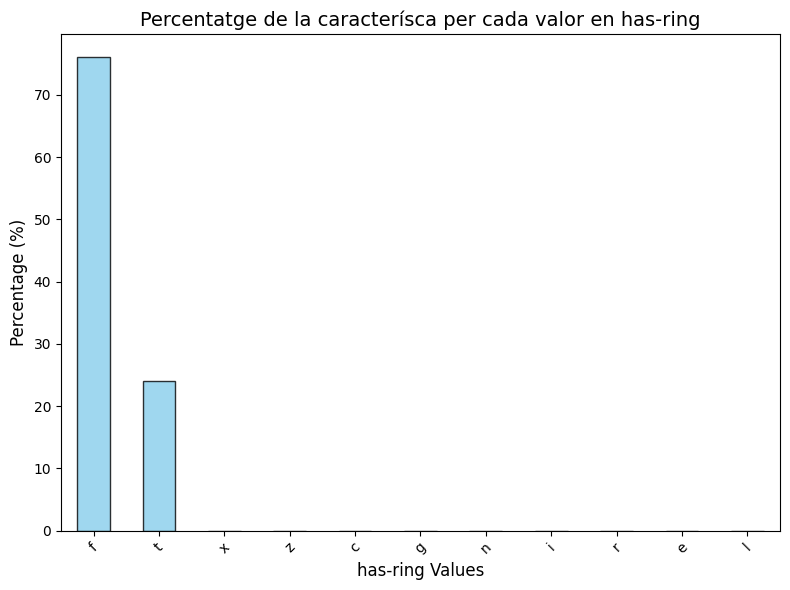

has-ring
f   76.0197
t   23.9768
x    0.0006
z    0.0006
c    0.0003
g    0.0003
n    0.0003
i    0.0003
r    0.0003
e    0.0003
l    0.0003
Name: proportion, dtype: float64



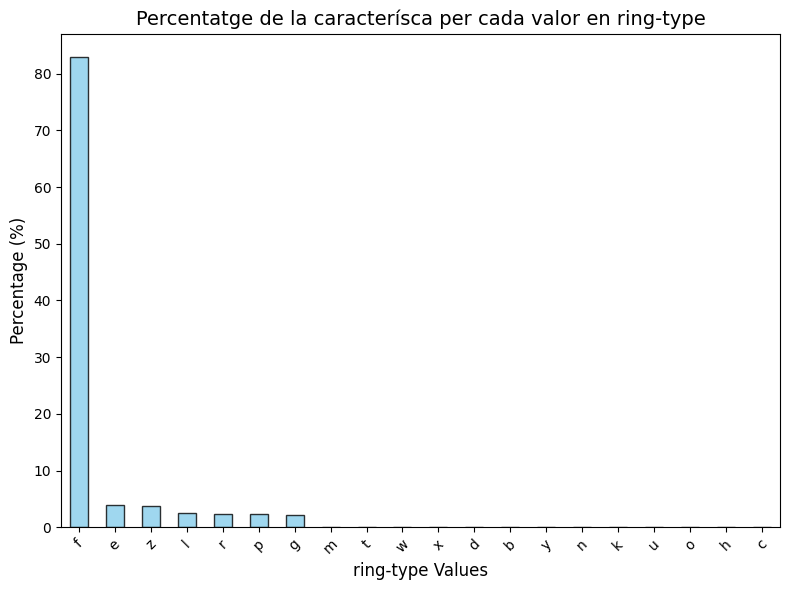

ring-type
f   82.8710
e    4.0120
z    3.7858
l    2.4599
r    2.2929
p    2.2819
g    2.1540
m    0.1285
t    0.0030
w    0.0017
x    0.0017
d    0.0017
b    0.0013
y    0.0013
n    0.0010
k    0.0007
u    0.0007
o    0.0003
h    0.0003
c    0.0003
Name: proportion, dtype: float64



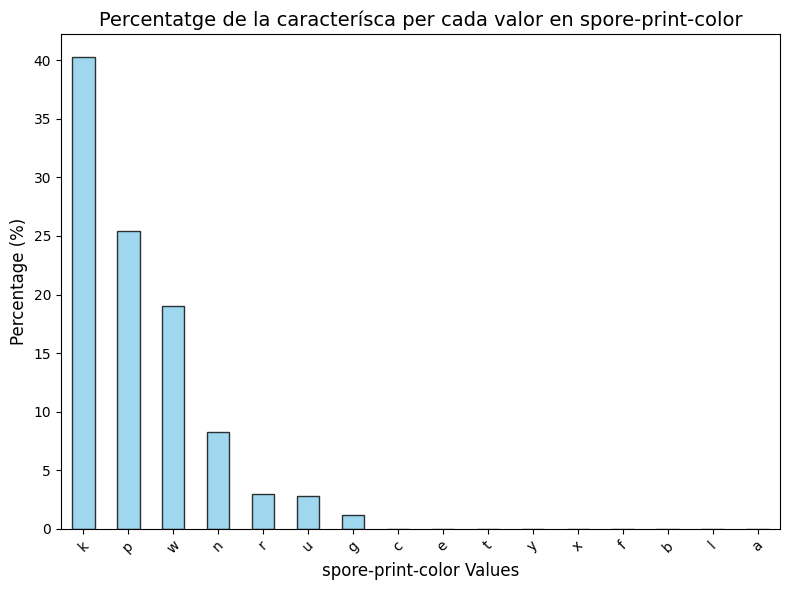

spore-print-color
k   40.2438
p   25.4147
w   19.0009
n    8.3023
r    3.0019
u    2.7687
g    1.2151
c    0.0113
e    0.0075
t    0.0075
y    0.0075
x    0.0038
f    0.0038
b    0.0038
l    0.0038
a    0.0038
Name: proportion, dtype: float64



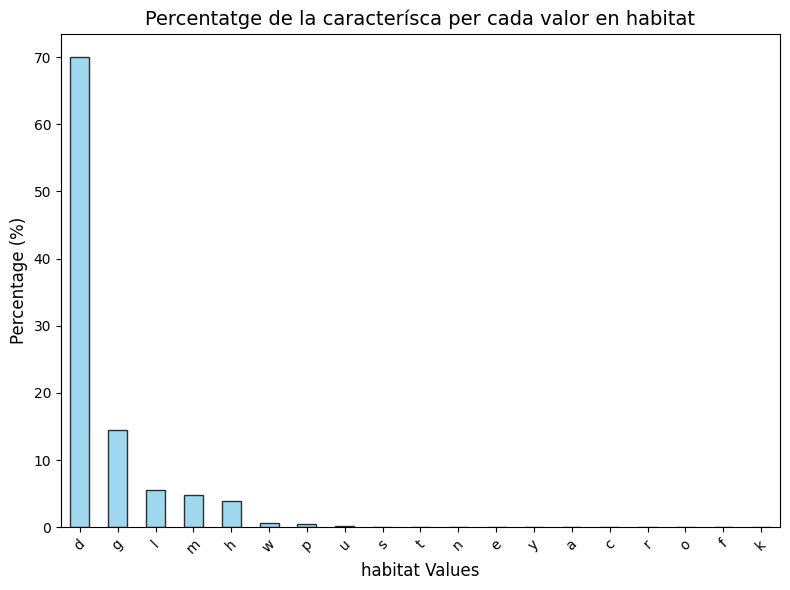

habitat
d   69.9768
g   14.5082
l    5.5126
m    4.8254
h    3.8523
w    0.5916
p    0.5409
u    0.1810
s    0.0029
t    0.0013
n    0.0013
e    0.0013
y    0.0013
a    0.0010
c    0.0006
r    0.0006
o    0.0003
f    0.0003
k    0.0003
Name: proportion, dtype: float64



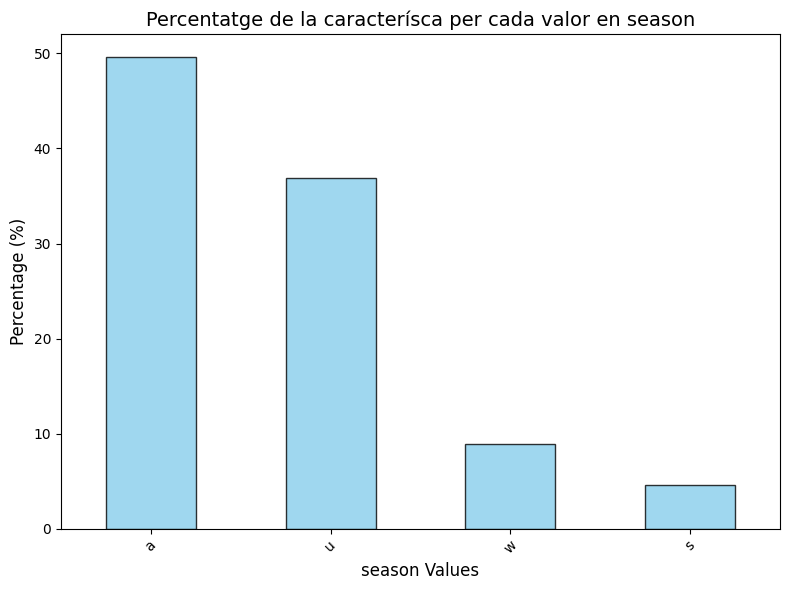

season
a   49.5727
u   36.9407
w    8.9306
s    4.5561
Name: proportion, dtype: float64



In [75]:
def plot_characteristic_percentages(df):
    for col in object_columns:
        if col in df.columns and col != 'class':
            value_counts = df[col].value_counts(normalize=True) * 100

            plt.figure(figsize=(8, 6))
            value_counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.8)
            plt.title(f'Percentatge de la caracterísca per cada valor en {col}', fontsize=14)
            plt.xlabel(f'{col} Values', fontsize=12)
            plt.ylabel('Percentage (%)', fontsize=12)
            plt.xticks(rotation=45, fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()
            print(value_counts)
            print("")

plot_characteristic_percentages(filtered_df)
plt.close()

Podem veure que els valors de cada característica en la majoria es concentren en poques classes.

# Anàlisis de les característiques numèriques

En les característiques contínues farem una anàlisi per veure com estan distribuïdes i si haurem d'eliminar valors anòmals abans de normalitzar.

In [76]:
pd.set_option('display.float_format', '{:.4f}'.format)
print(filtered_df.describe())

       cap-diameter  stem-height  stem-width
count   311694.0000  311694.0000 311694.0000
mean         6.3130       6.3522     11.1683
std          4.6587       2.7050      8.1068
min          0.4000       0.0000      0.0000
25%          3.3200       4.6700      4.9900
50%          5.7600       5.8800      9.6700
75%          8.2400       7.4200     15.6500
max         58.4000      53.9300    102.4800


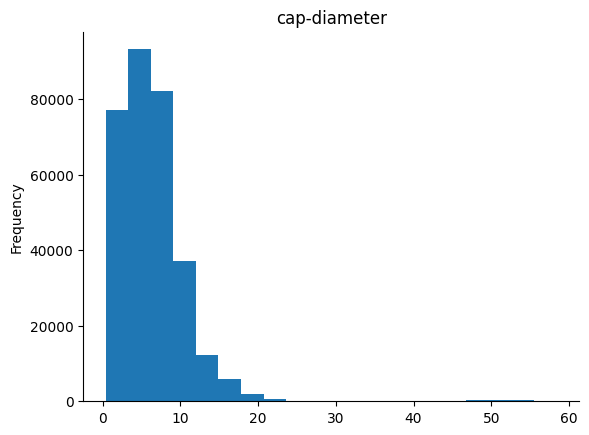

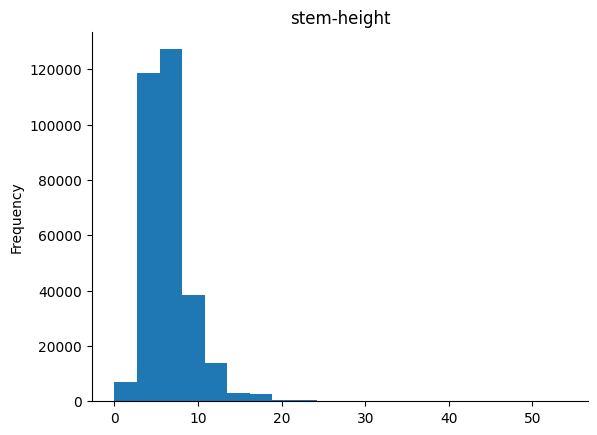

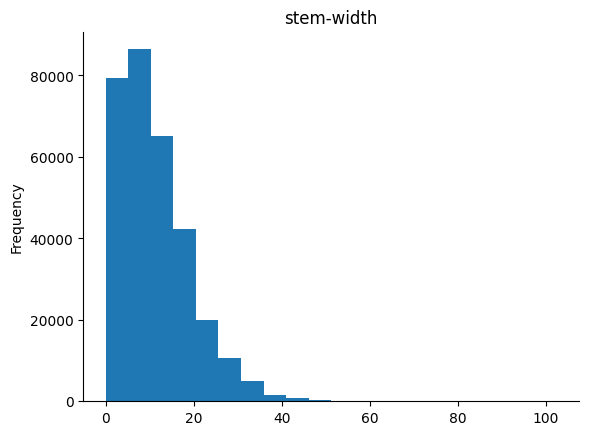

In [77]:
for col in numeric_columns:
    filtered_df[col].plot(kind='hist', bins=20, title=col)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
    print("")

En els tres casos la majoria de valors es concentren al principi, però la grafica arriba molt més enllà, aixó ens indica que tenim uns pocs valors en el extrem dret que ens modificaran molt la normalització, aquets valors anomals els haurem de tractar.

# Relació de les variables categòriques amb el target

Per buscar les relacions entre les variables categoriques i el target mostrarem una serie de grafics on indicarem el percentatge dels valors que pertanyen a cada una de les classes objectiu "e" i "p", si aquest percentatge és proper al 50% llavors no ens dona cap informació, en canvi els percentatges més extrems ens indicaran que si te aquell atribut és més facil assegurar a quina classe pertany.

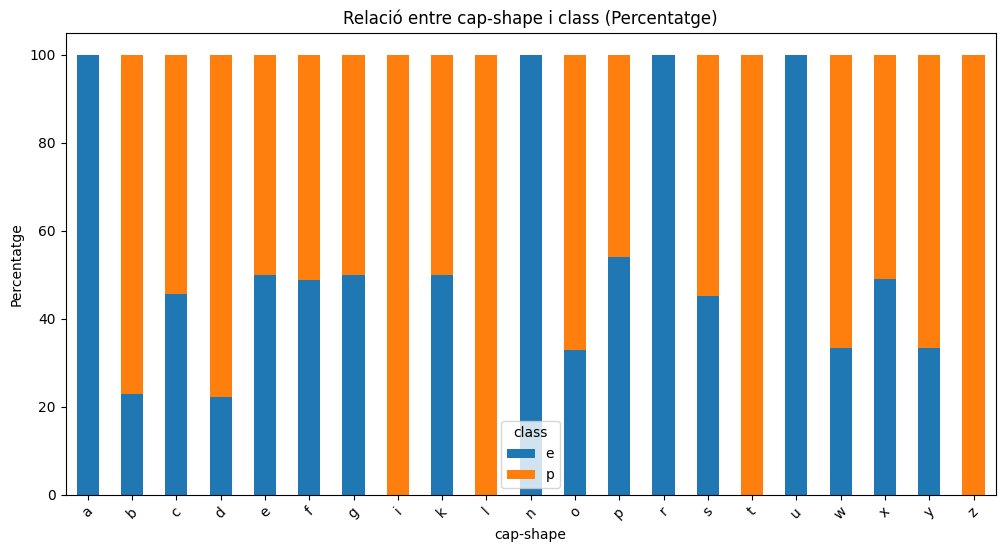

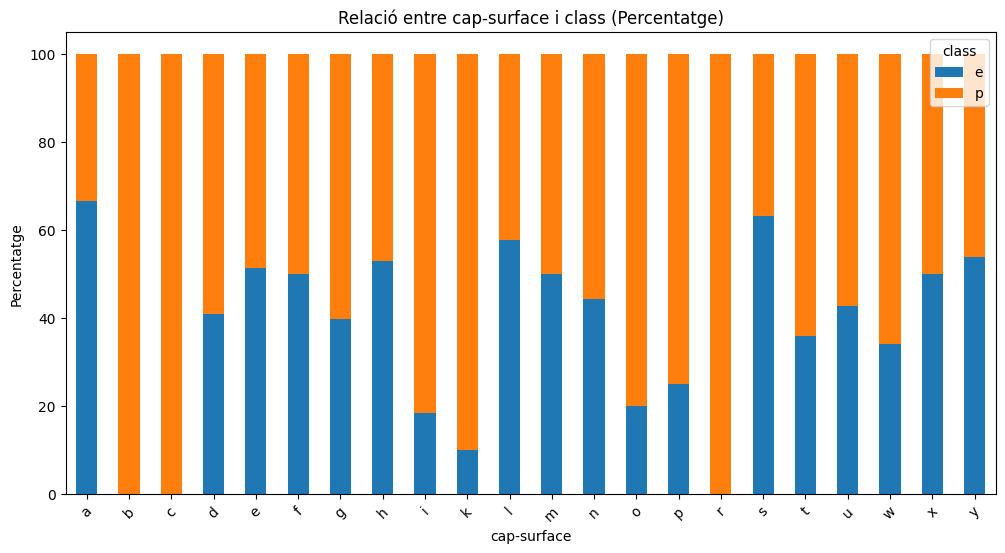

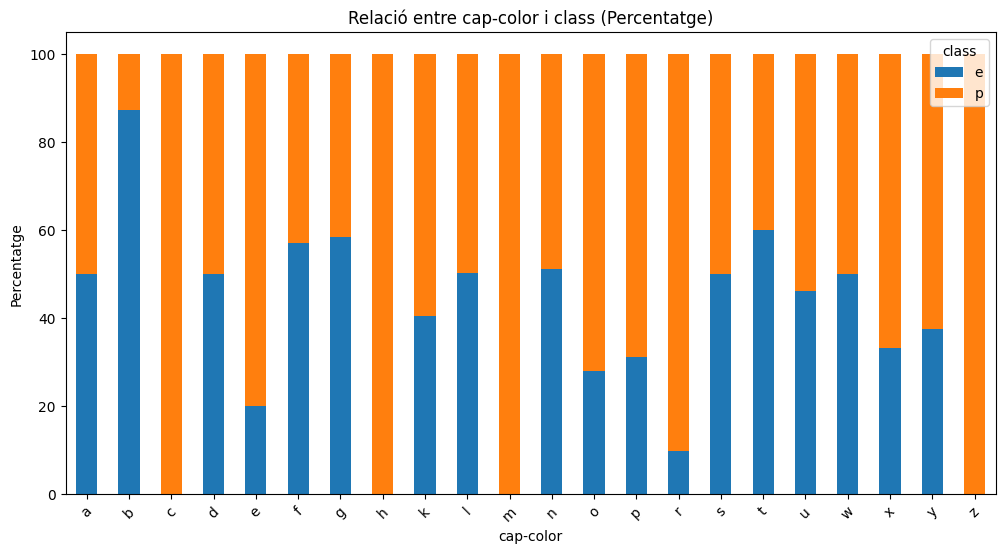

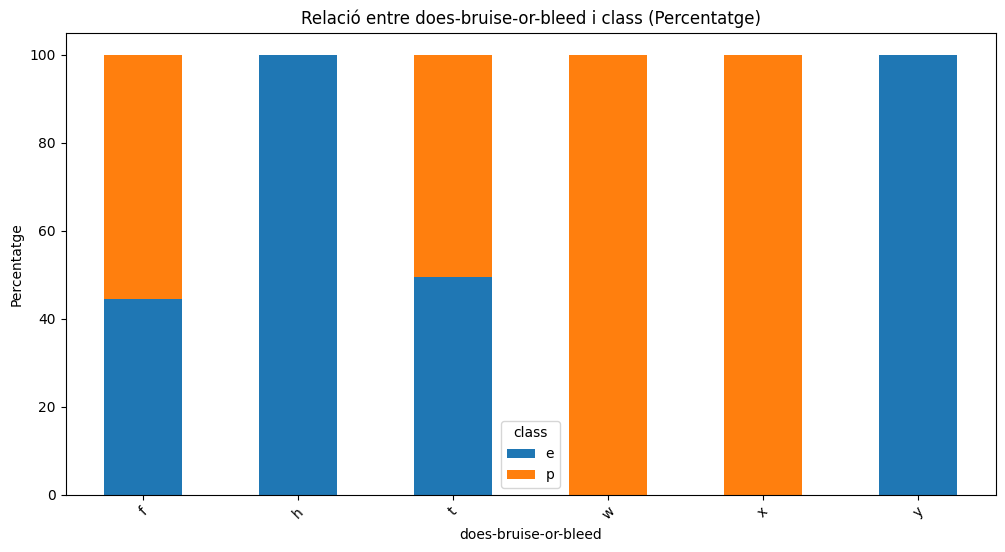

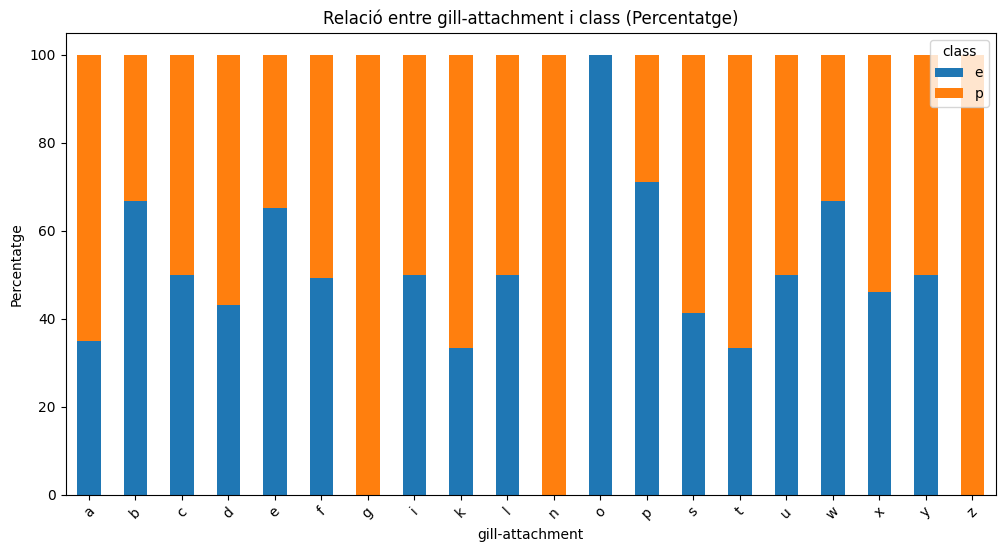

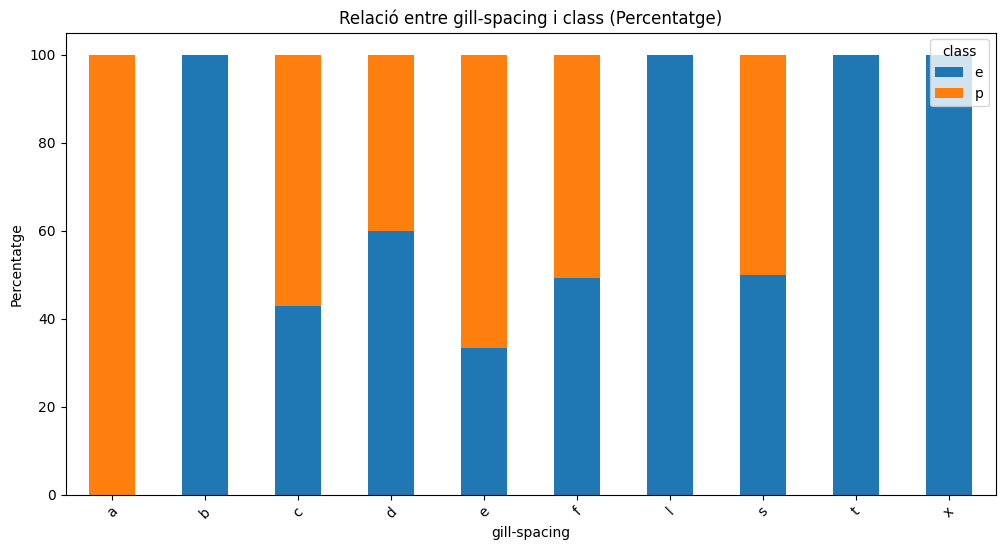

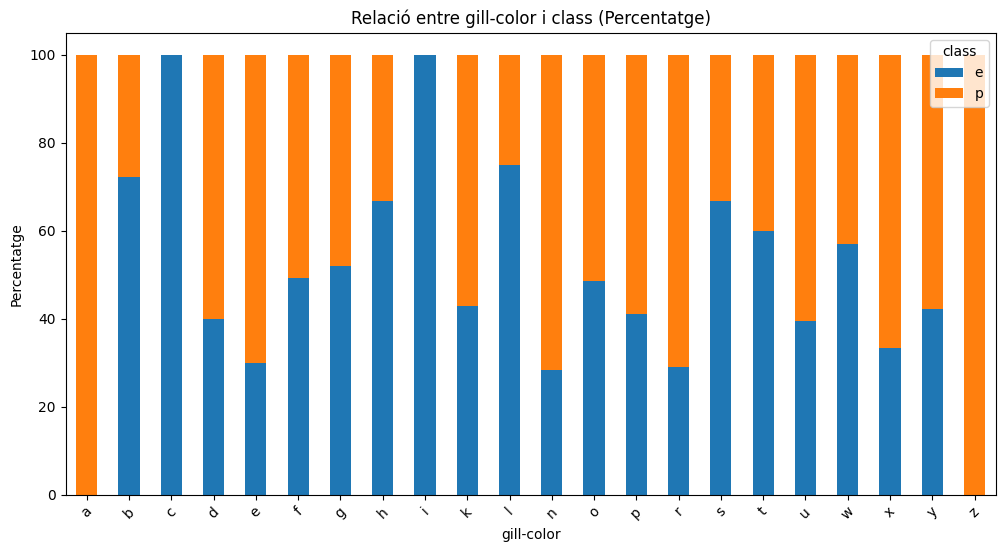

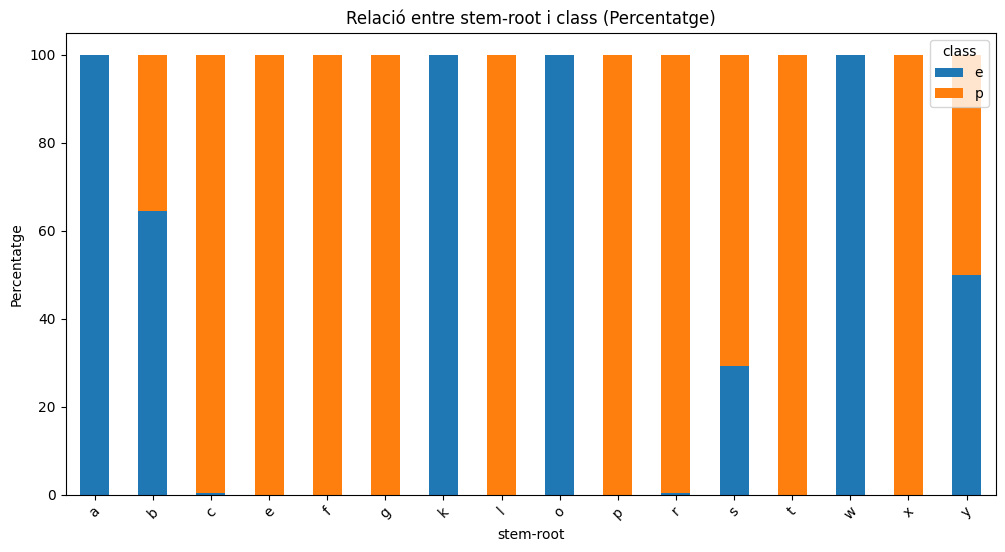

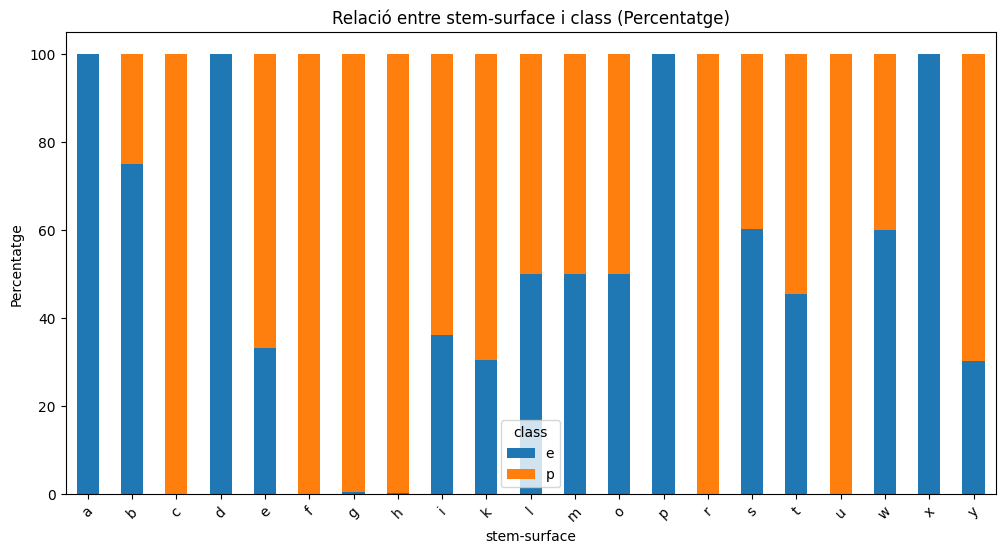

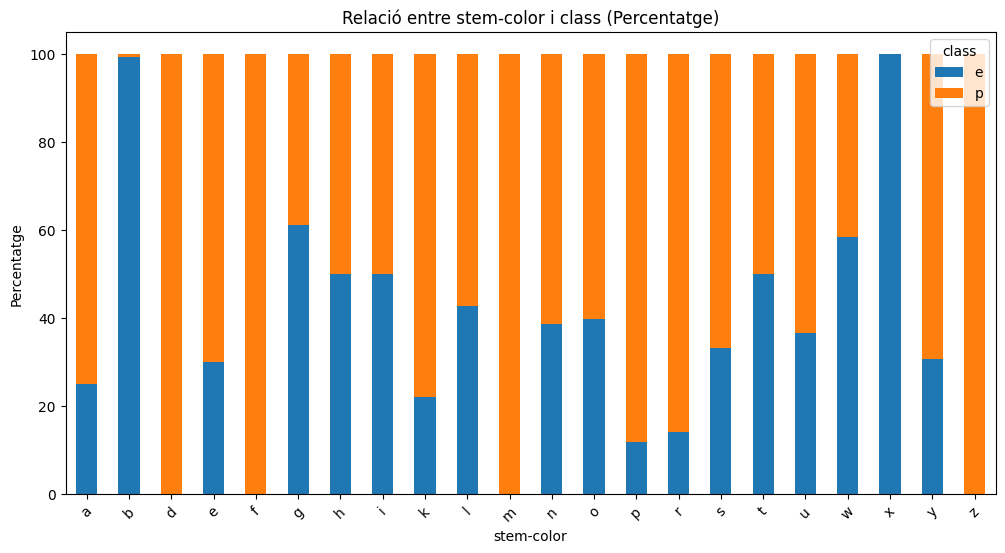

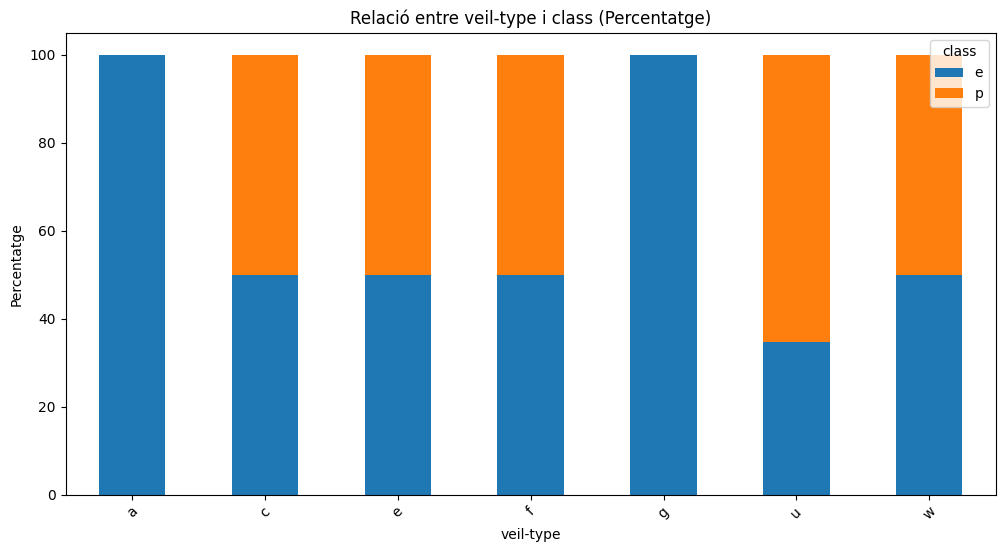

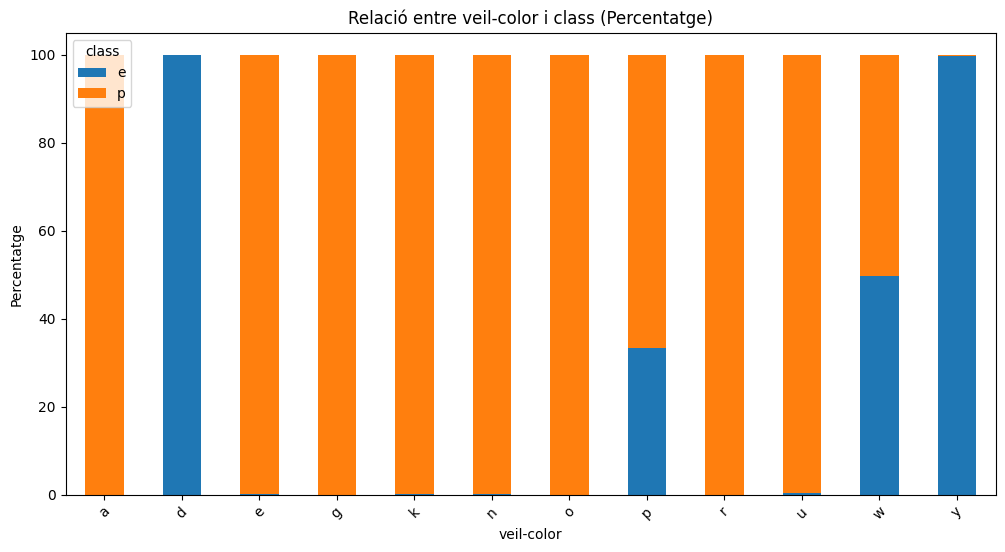

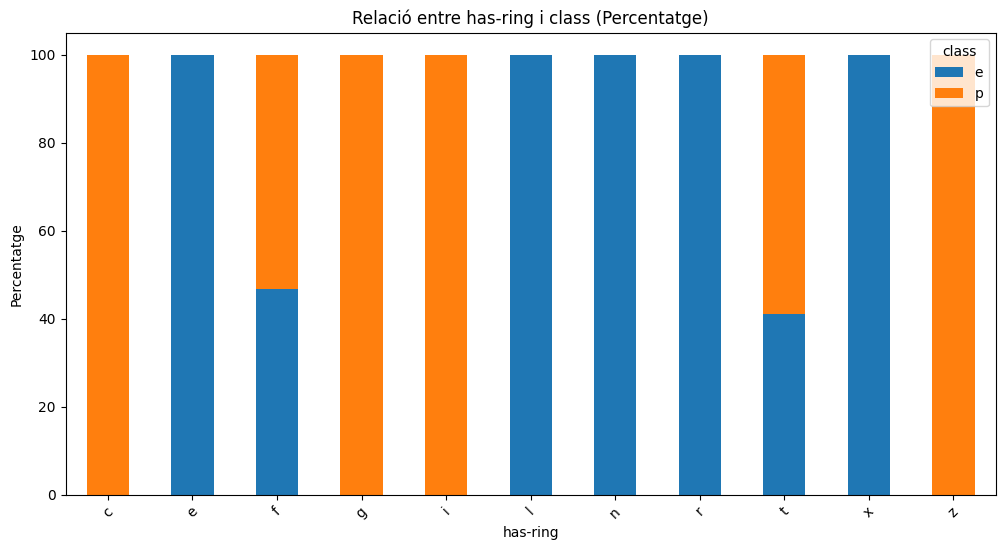

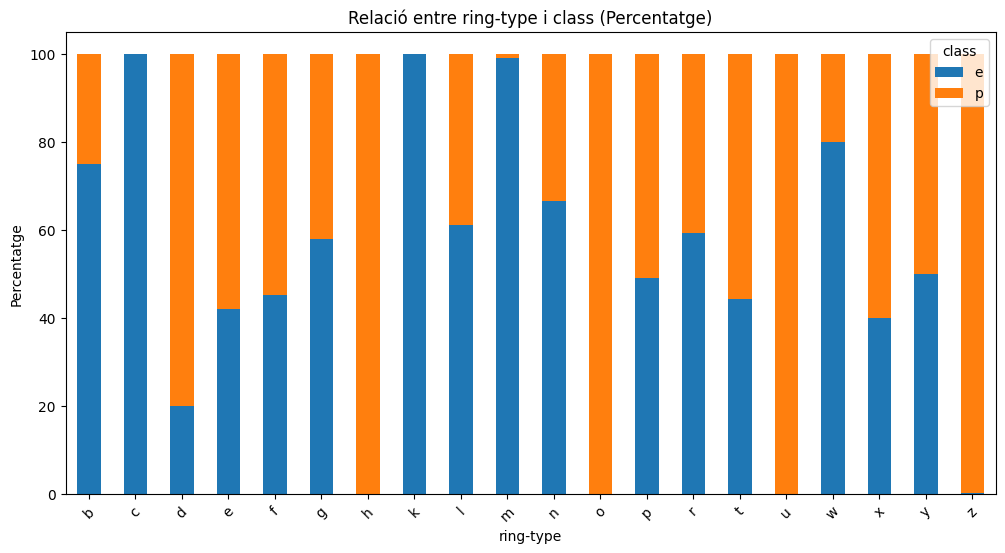

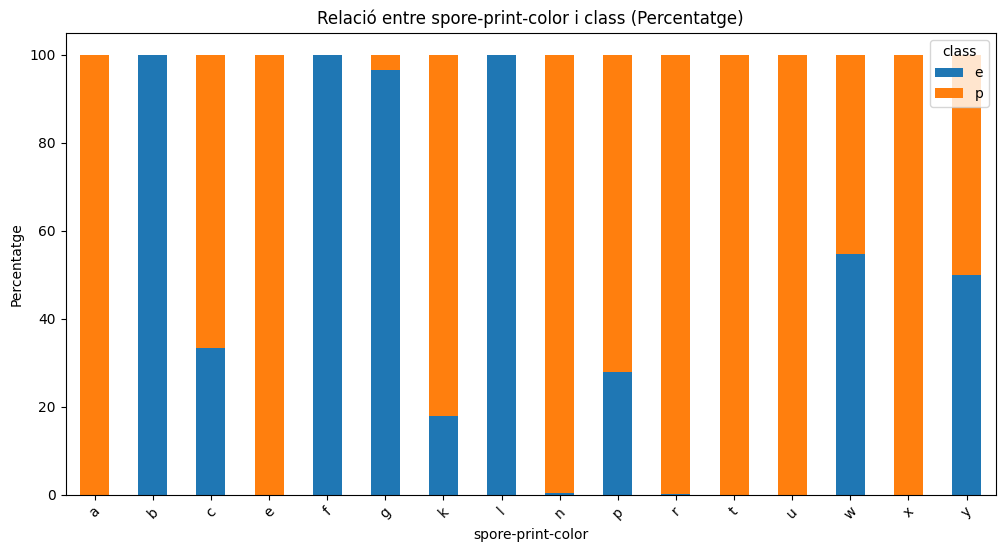

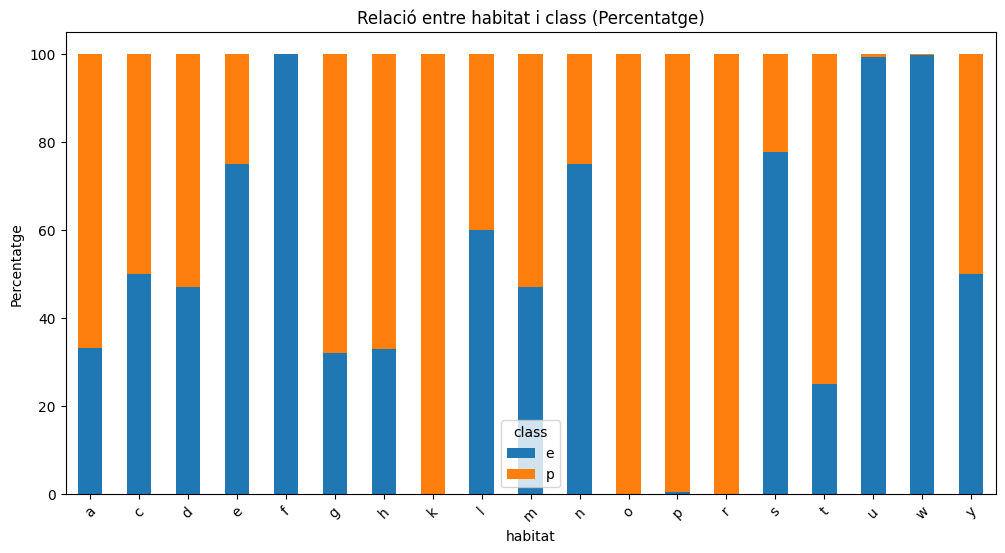

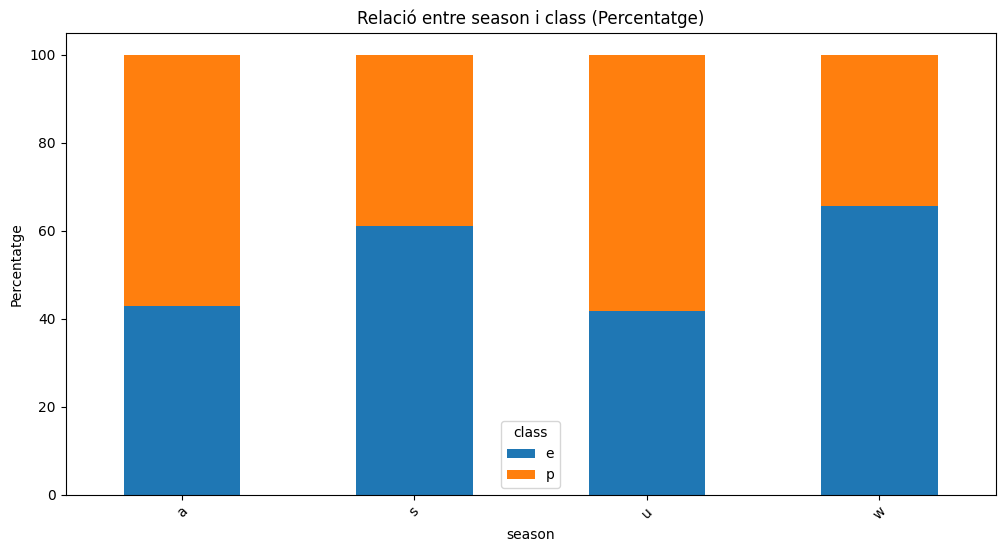

In [78]:
def plot_categorical_target_relation(df, target_column):
    for column in object_columns:
        if column != target_column and column in df.columns:
            plt.figure(figsize=(12, 6))
            cross_tab = pd.crosstab(df[column], df[target_column], normalize='index') * 100
            cross_tab.plot(kind='bar', stacked=True, ax=plt.gca())
            plt.title(f'Relació entre {column} i {target_column} (Percentatge)')
            plt.xticks(rotation=45)
            plt.ylabel('Percentatge')
            plt.legend(title=target_column)
            plt.show()
            print("")
plot_categorical_target_relation(filtered_df, 'class')
plt.close()

A simple vista podem veure que hi han valors de característiques les quals només pertanyen pràcticament a la classe 'p' com pot ser veil-color = n, e, u que corresponen a venenosos, de la classe 'e' en canvi, no hi ha cap valor en cap característica que ens digui sí o sí que aquell bolet és comestible, però tenim alguns valors, que són majoritariament de la classe 'e' com per exemple stem-root = 'b'.

# Relació de variables numèriques amb el target

Al igual que hem fet amb les caracteristiques categoriques ara analitzarem la relació entre les caracteristiques continues i el target.

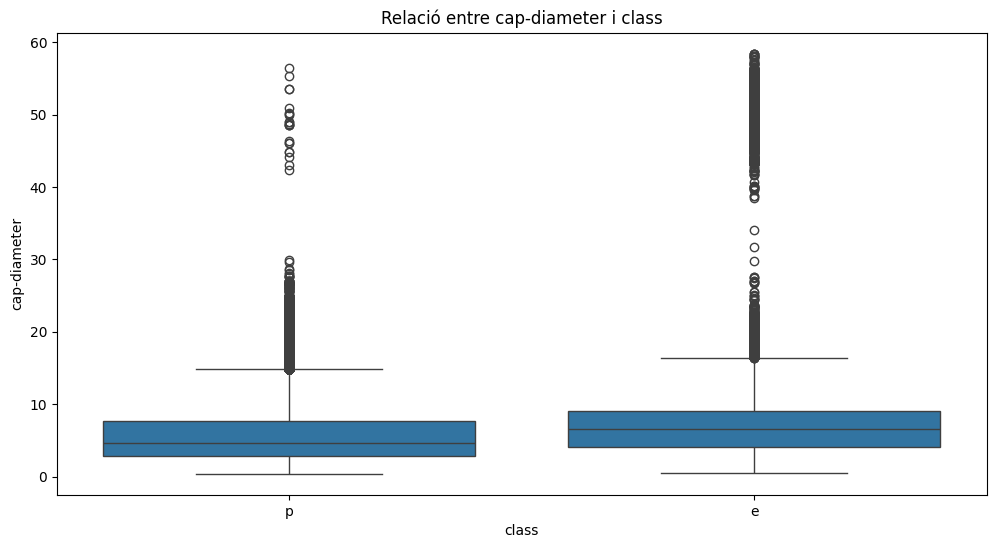

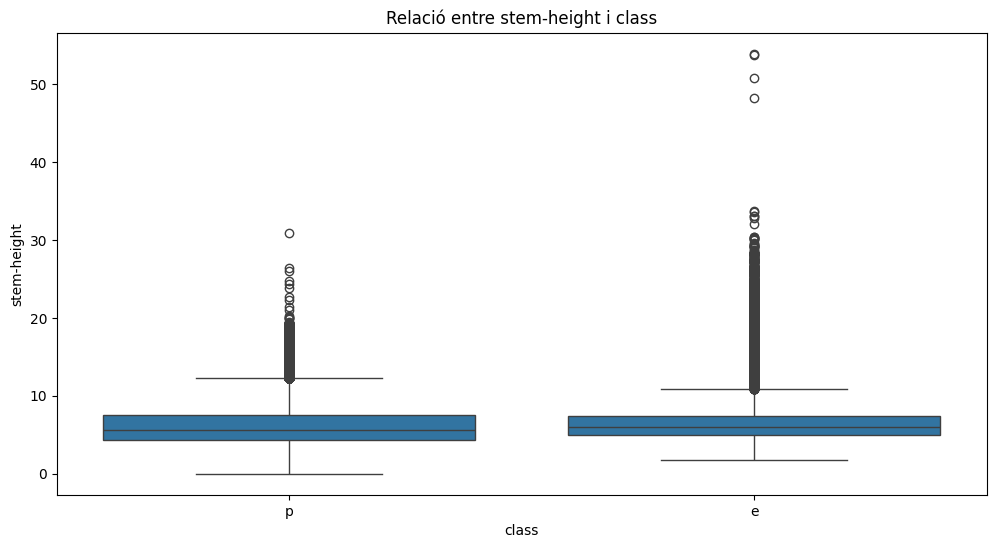

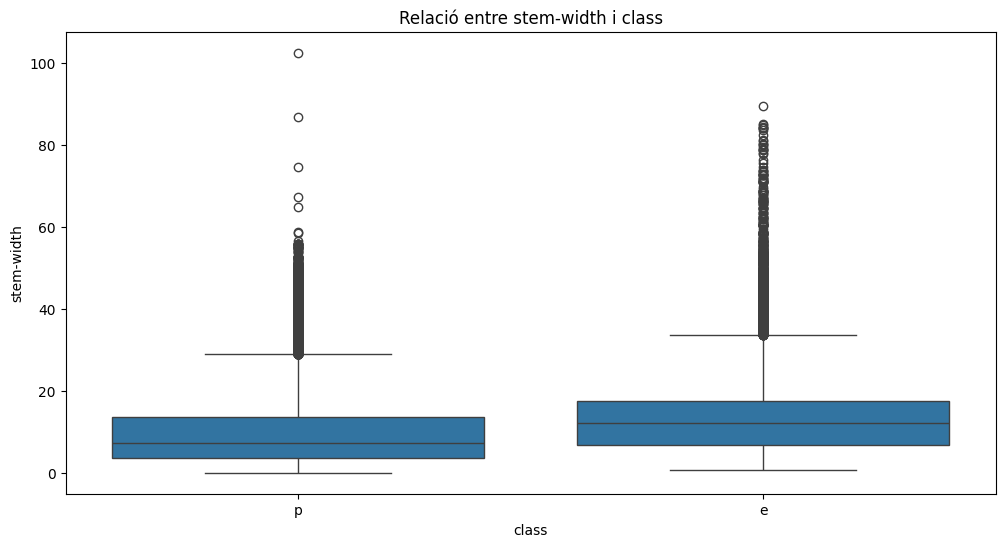

In [79]:
def plot_numeric_target_relation(df, target_column):
    for column in numeric_columns:
        if column != target_column and column in df.columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=target_column, y=column, data=df)
            plt.title(f'Relació entre {column} i {target_column}')
            plt.show()
            print("")

plot_numeric_target_relation(filtered_df, 'class')
plt.close()

Tot i que hi han petites diferencies no podem indicar si és comestible o no només mirant les relacions amb aquestes tres caracteristiques individualment. En aquestes gràfiques també es pot apreciar més facilment els outliers que haurem de tractar en el preprocessament.

# Preprocessament

Abans de res, dividim el dataset en train i test per evitar trobar-nos en una situació de 'data leakage'.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1), df['class'], test_size=0.3, random_state=42)

## Tractament de valors outliers

Com hem dit abans en les variables continues necesitem fer un tractament de valors anomals, per a fer el tractament utilitzarem el mètode del rang interquantil amb un threshold, calculem el quartil inferior i superior, el rang interquantil i creem els límits del domini, si alguna variable supera el límit, utilitzem la funció .clip per ajustar el seu valor al límit inferior o superior depenen del valor.

In [ ]:
def tractar_outliers_train(train, columns, threshold=1.5):
    limits = {}
    df_treated = train
    for column in numeric_columns:
      Q1 = df_treated[column].quantile(0.25)
      Q3 = df_treated[column].quantile(0.75)
      IQR = Q3 - Q1
      limit_inferior = Q1 - threshold * IQR
      limit_superior = Q3 + threshold * IQR
      limits[column] = (limit_inferior, limit_superior)
      df_treated[column] = df_treated[column].clip(limit_inferior, limit_superior)
    return df_treated, limits

def tractar_outliers_test(test, columns, limits):
    df_treated = test
    for column in numeric_columns:
      limit_inferior, limit_superior = limits[column]
      df_treated[column] = df_treated[column].clip(limit_inferior, limit_superior)
    return df_treated

## Tractament de valors null

Pel tractament de valors null, primer mirarem quin percentatge de valors tenim a cada característica, si tenim valors molt alts, simplement eliminarem la característica. Utilitzarem un threshold del 85%.

In [82]:
def null_percentage(X_train):
    nulls = X_train.isnull().sum()
    percentatges = (nulls / len(df)) * 100
    return percentatges

In [ ]:
def delete_null_columns(X_train, X_test):
    percentatges = null_percentage(X_train)
    threshold = 80
    columnes_a_eliminar = percentatges[percentatges > threshold].index
    X_train = X_train.drop(columns=columnes_a_eliminar)
    X_test = X_test.drop(columns=columnes_a_eliminar)
    return X_train, X_test
    #df_test = df_test.drop(columns=columnes_a_eliminar)


Per les columnes restants com a punt d'inici utilitzarem la mediana per les columnes numèriques i la moda per les categòriques, hem fet proves amb altres mètodes però el temps de preprocessament augment molt i no obtenim millores significatives, treballant amb un dataset tant gran no ens ho podem permetre.

In [84]:
def fill_nans(X_train, X_test):
    for column in X_train.columns:
        if X_train[column].dtype == 'object':
            moda_train = X_train[column].mode()[0]
            X_train[column].fillna(moda_train, inplace=True)
            X_test[column].fillna(moda_train, inplace=True)
            #df_test[column].fillna(moda_train, inplace=True)
        elif X_train[column].dtype == 'float64':
            mediana_train = X_train[column].median()
            X_train[column].fillna(mediana_train, inplace=True)
            X_test[column].fillna(mediana_train, inplace=True)
    return X_train, X_test

## Codificació de les característiques

Ara farem els encodings per a totes les categories ordinals i nominals.

Per a les nominals utilitzarem el OneHotEncoder, aquesta tecnica converteix cada columna en N columnes binaries, on N és el nombre de valors unics en la columna, per exemple en cas de tenir una columna "color" amb 3 valors [r, g, b], ho convertiries a [[1,0,0],[0,1,0],[0,0,1]], la forma més intuitiva d'entendre aquesta transformació és que el valor binari t'indica si la columna te o no aquell valor.

En el cas de les columnes ordinals utilitzarem el ordinalEncoder, aquest encoder transforma aquelles columnes ordinals que tenen els valors en forma no numerica a valors numerics, seguin el exemple anterior, si tens una columna color amb els valors [r,g,b] la transformaria a una sola columna amb valors [0,1,2].

Aquests encodings els hem de fer separant el train i test per evitar el data leakage que ens podria modificar els resultats de l'encoding i faria que els resultats no fosin tan valids.

In [85]:
ordinal_columns = ['gill-spacing', 'gill-color', 'ring-type']
numeric_columns = ['cap-diameter', 'stem-height', 'stem-width']
nominal_columns = [col for col in X_train.columns if col not in ordinal_columns and col not in numeric_columns]
ordinal_columns = [col for col in X_train.columns if col not in nominal_columns and col not in numeric_columns]


def fit_encode_nominals(df_train):
    # Use sparse output to save memory
    encoder = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    temp_train = encoder.fit_transform(df_train[nominal_columns])  # Sparse matrix

    # Convert sparse matrix to DataFrame with sparse format
    temp_train_df = pd.DataFrame.sparse.from_spmatrix(temp_train, columns=encoder.get_feature_names_out(nominal_columns))

    # Drop nominal columns and concatenate the sparse DataFrame
    df_train_transformed = pd.concat([df_train.drop(columns=nominal_columns).reset_index(drop=True), temp_train_df], axis=1)
    
    return df_train_transformed, encoder, nominal_columns

def transform_nominals(df_test, encoder, nominal_columns):
    # Transform test data using the same encoder
    temp_test = encoder.transform(df_test[nominal_columns])  # Sparse matrix

    # Convert sparse matrix to DataFrame with sparse format
    temp_test_df = pd.DataFrame.sparse.from_spmatrix(temp_test, columns=encoder.get_feature_names_out(nominal_columns))

    # Drop nominal columns and concatenate the sparse DataFrame
    df_test_transformed = pd.concat([df_test.drop(columns=nominal_columns).reset_index(drop=True), temp_test_df], axis=1)

    del encoder

    return df_test_transformed

def fit_encode_ordinals(df_train):
    ordinal_encoders = {}
    for col in ordinal_columns:
        if col in df_train.columns:
            encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            df_train[col] = encoder.fit_transform(df_train[[col]]).ravel()  # Transform column
            ordinal_encoders[col] = encoder
    return df_train, ordinal_encoders

def transform_ordinals(df_test, ordinal_encoders):
    for col, encoder in ordinal_encoders.items():
        if col in df_test.columns:
            df_test[col] = encoder.transform(df_test[[col]]).ravel()  # Transform column
    del ordinal_encoders  
    return df_test

def fit_encode_target(y_train):
    target_encoder = LabelEncoder()
    y_train_encoded = target_encoder.fit_transform(y_train)
    return y_train_encoded, target_encoder

def transform_target(y_test, target_encoder):
    y_test_encoded = target_encoder.transform(y_test)
    del target_encoder
    return y_test_encoded
"""
# Memory-efficient encoding pipeline
# 1. Nominal encoding
X_train, nominal_encoder, nominal_cols = fit_encode_nominals(X_train)
X_test = transform_nominals(X_test, nominal_encoder, nominal_cols)
df_test = transform_nominals(df_test, nominal_encoder, nominal_cols)
# 2. Ordinal encoding
X_train, ordinal_encoders = fit_encode_ordinals(X_train)
X_test = transform_ordinals(X_test, ordinal_encoders)
df_test = transform_ordinals(df_test, ordinal_encoders)
# 3. Target encoding
y_train, target_encoder = fit_encode_target(y_train)
y_test = transform_target(y_test, target_encoder)
"""


'\n# Memory-efficient encoding pipeline\n# 1. Nominal encoding\nX_train, nominal_encoder, nominal_cols = fit_encode_nominals(X_train)\nX_test = transform_nominals(X_test, nominal_encoder, nominal_cols)\ndf_test = transform_nominals(df_test, nominal_encoder, nominal_cols)\n# 2. Ordinal encoding\nX_train, ordinal_encoders = fit_encode_ordinals(X_train)\nX_test = transform_ordinals(X_test, ordinal_encoders)\ndf_test = transform_ordinals(df_test, ordinal_encoders)\n# 3. Target encoding\ny_train, target_encoder = fit_encode_target(y_train)\ny_test = transform_target(y_test, target_encoder)\n'

# Eliminació de columnes no rellevants

Originalment haviem pensat en eliminar les columnes amb una baixa correlació, aixó ho voliem fer principalment per millorar el rendiment i disminuir l'ús de memoria, ja que si tenim menys dades en el moment d'entrenar el model millorarem el rendiment. Ademés si eliminem les columnes amb una baixa correlació no hauria de modificar massa el resultat final, perque estem eliminant dades que donen poca informació.

Al final aixó no ho hem fet perque aquesta hipotesi no ha funcionat, el rendiment milloraba per molt poc i el resultat final empitjoraba més del que haviem imaginat inicialment.

In [86]:
def remove_low_correlation_features(df, X_test, target_column, threshold=0.05):
    correlations = df.drop(columns=[target_column]).apply(lambda col: col.corr(df[target_column]))
    low_correlation_columns = correlations[abs(correlations) < threshold].index.tolist()
    X_train = df.drop(columns=low_correlation_columns + [target_column], errors='ignore')
    X_test = X_test.drop(columns=low_correlation_columns, errors='ignore')
    
    return X_train, X_test

# Escalar dades

Originalment haviem pensat en eliminar les columnes amb una baixa correlació, aixó ho voliem fer principalment per millorar el rendiment i disminuir l'ús de memoria, ja que si tenim menys dades en el moment d'entrenar el model millorarem el rendiment. Ademés si eliminem les columnes amb una baixa correlació no hauria de modificar massa el resultat final, perque estem eliminant dades que donen poca informació.

Al final aixó no ho hem fet perque aquesta hipotesi no ha funcionat, el rendiment milloraba per molt poc i el resultat final empitjoraba més del que haviem imaginat inicialment.

In [87]:
import gc
gc.collect()
def scale_and_encode(X_train, X_test):
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    del X_train
    gc.collect()

    X_test_scaled = scaler.transform(X_test)
    del X_test
    del scaler
    gc.collect()
    """
    df_test_scaled = scaler.transform(df_test)
    del df_test
    gc.collect()
    """
    return X_train_scaled, X_test_scaled
#X_train, X_test = scale_and_encode(X_train, X_test, df_test)

## Funcions útils

Tenim aquesta funció que junta tots els mètodes de preprocessament de les dades, aquesta l'utilitzem també en el mètode de validació creuada per cada partició que es genera, d'aquesta forma evitem el "data-leakage".

In [144]:
def preprocess(X_train, X_test, y_train, y_test):
    ordinal_columns = ['gill-spacing', 'gill-color', 'ring-type']
    numeric_columns = ['cap-diameter', 'stem-height', 'stem-width']
    nominal_columns = [col for col in X_train.columns if col not in ordinal_columns and col not in numeric_columns]
    ordinal_columns = [col for col in X_train.columns if col not in nominal_columns and col not in numeric_columns]

    X_train, X_test = delete_null_columns(X_train, X_test)
    
    X_train, limits = tractar_outliers_train(X_train, numeric_columns)
    X_test = tractar_outliers_test(X_test, numeric_columns, limits)
    
    #X_train, X_test = fill_nans(X_train, X_test)

    # 1. Nominal encoding
    X_train, nominal_encoder, nominal_cols = fit_encode_nominals(X_train)
    X_test = transform_nominals(X_test, nominal_encoder, nominal_cols)
    #df_test = transform_nominals(df_test, nominal_encoder, nominal_cols)
    # 2. Ordinal encoding
    X_train, ordinal_encoders = fit_encode_ordinals(X_train)
    X_test = transform_ordinals(X_test, ordinal_encoders)
    #df_test = transform_ordinals(df_test, ordinal_encoders)
    # 3. Target encoding
    y_train, target_encoder = fit_encode_target(y_train)
    y_test = transform_target(y_test, target_encoder)

    #X_train, X_test = remove_low_correlation_features(df, X_test, 'class', threshold=0.05)
    X_train, X_test = scale_and_encode(X_train, X_test)

    gc.collect()
    
    return X_train, X_test, y_train, y_test


    

Hem fet aquesta funció per fer la validació creuada, l'hem creat manualment perquè no hem pogut utilitzar un pipeline amb diferents encoders, per tant, vam decidir fer-la a mà i aplicar el preprocessament a cada partició.

In [96]:
def manual_cross_validation(model, X, y, cv=5, verbose=True):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    mcc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        X_train, X_val, y_train, y_val = preprocess(X_train, X_val, y_train, y_val)

        model.fit(X_train, y_train)

        predictions = model.predict(X_val)

        acc = accuracy_score(y_val, predictions)
        f1 = f1_score(y_val, predictions, average='weighted')
        mcc = matthews_corrcoef(y_val, predictions)

        accuracies.append(acc)
        f1_scores.append(f1)
        mcc_scores.append(mcc)

        if verbose:
            print(f"Partició {fold}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, MCC = {mcc:.4f}")

    metrics = {
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores),
        'mean_mcc': np.mean(mcc_scores),
        'std_mcc': np.std(mcc_scores),
        'fold_accuracies': accuracies,
        'fold_f1_scores': f1_scores,
        'fold_mcc_scores': mcc_scores
    }

    if verbose:
        print(f"\nAccuracy: {metrics['mean_accuracy']:.4f} ± {metrics['std_accuracy']:.4f}")
        print(f"F1 Score: {metrics['mean_f1']:.4f} ± {metrics['std_f1']:.4f}")
        print(f"MCC: {metrics['mean_mcc']:.4f} ± {metrics['std_mcc']:.4f}")

    return metrics

Funció per comparar models utilitzant les mètriques d'accuracy, f1-score i MCC i graficar els resultats.

In [140]:
def compare_models_cv(models, model_names, X, y, cv=5, verbose=True):
    metrics_list = []
    
    for model, name in zip(models, model_names):
        if verbose:
            print(f"\nEvaluant model: {name}")
        
        start_time = time.time()
        metrics = manual_cross_validation(model, X, y, cv=cv, verbose=verbose)
        end_time = time.time()
        
        elapsed_time = end_time - start_time  # Temps en segons
        
        metrics_list.append({
            'Model': name,
            'Mitjana Accuracy': metrics['mean_accuracy'],
            'Desviació Accuracy': metrics['std_accuracy'],
            'Mitjana F1 Score': metrics['mean_f1'],
            'Desviació F1 Score': metrics['std_f1'],
            'Mitjana MCC': metrics['mean_mcc'],
            'Desviació MCC': metrics['std_mcc'],
            'Temps (s)': elapsed_time
        })
    
    results_df = pd.DataFrame(metrics_list)
    
    # Configurar el gràfic amb una quadrícula 2x2
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(24, 16))
    
    # Posicions per a l'eix X
    x_positions = np.arange(len(results_df))

    # Accuracy Plot
    sns.barplot(x='Model', y='Mitjana Accuracy', data=results_df, ax=axes[0,0], palette="Blues_d", ci=None)
    # Afegir barres d'error
    axes[0,0].errorbar(x=x_positions, 
                       y=results_df['Mitjana Accuracy'], 
                       yerr=results_df['Desviació Accuracy'], 
                       fmt='none', c='black', capsize=5)
    # Crear etiquetes amb el valor de Accuracy
    accuracy_labels = [f"{name} ({acc:.4f})" for name, acc in zip(results_df['Model'], results_df['Mitjana Accuracy'])]
    axes[0,0].set_xticklabels(accuracy_labels, rotation=45, ha='right')
    axes[0,0].set_title('Mitjana Accuracy', fontsize=16, fontweight='bold')
    axes[0,0].set_ylim(0.985, 0.996)

    # F1 Score Plot
    sns.barplot(x='Model', y='Mitjana F1 Score', data=results_df, ax=axes[0,1], palette="Greens_d", ci=None)
    axes[0,1].errorbar(x=x_positions, 
                       y=results_df['Mitjana F1 Score'], 
                       yerr=results_df['Desviació F1 Score'], 
                       fmt='none', c='black', capsize=5)
    # Crear etiquetes amb el valor de F1 Score
    f1_labels = [f"{name} ({f1:.4f})" for name, f1 in zip(results_df['Model'], results_df['Mitjana F1 Score'])]
    axes[0,1].set_xticklabels(f1_labels, rotation=45, ha='right')
    axes[0,1].set_title('Mitjana F1 Score', fontsize=16, fontweight='bold')
    axes[0,1].set_ylim(0.985, 0.996)  # Ajusta segons els teus valors

    # MCC Plot
    sns.barplot(x='Model', y='Mitjana MCC', data=results_df, ax=axes[1,0], palette="Reds_d", ci=None)
    axes[1,0].errorbar(x=x_positions, 
                       y=results_df['Mitjana MCC'], 
                       yerr=results_df['Desviació MCC'], 
                       fmt='none', c='black', capsize=5)
    # Crear etiquetes amb el valor de MCC
    mcc_labels = [f"{name} ({mcc:.3f})" for name, mcc in zip(results_df['Model'], results_df['Mitjana MCC'])]
    axes[1,0].set_xticklabels(mcc_labels, rotation=45, ha='right')
    axes[1,0].set_title('Mitjana MCC', fontsize=16, fontweight='bold')
    axes[1,0].set_ylim(0.978, 0.986)  

    sns.barplot(x='Model', y='Temps (s)', data=results_df, ax=axes[1,1], palette="Purples_d", ci=None)
    axes[1,1].errorbar(x=x_positions, 
                       y=results_df['Temps (s)'], 
                       yerr=0,  
                       fmt='none', c='black', capsize=5)
    time_labels = [f"{name} ({time_val:.2f})" for name, time_val in zip(results_df['Model'], results_df['Temps (s)'])]
    axes[1,1].set_xticklabels(time_labels, rotation=45, ha='right')
    axes[1,1].set_title('Temps de Cross-Validació (segons)', fontsize=16, fontweight='bold')
    
    plt.tight_layout(pad=4)
    plt.show()
    
    return results_df

Funció per realitzar un grid search i trobar els millors paràmetres d'un model, l'hem fet manualment pel mateix motiu que per la funció de validació creuada.

In [90]:
def grid_search_cv(model, param_grid, X, y, cv=5, verbose=True):
    # Generar totes les combinacions de paràmetres
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
    
    best_params = None
    best_metrics = {'mean_accuracy': -np.inf}
    all_results = []

    if verbose:
        print(f"Grid search amb {len(param_combinations)} combinacions de paràmetres...\n")

    for i, param_values in enumerate(param_combinations, 1):
        start = time.time()
        params = dict(zip(param_names, param_values))
        
        if verbose:
            print(f"Evaluant combinació {i}/{len(param_combinations)}: {params}")
        
        model_clone = copy.deepcopy(model)
        model_clone.set_params(**params)
        
        metrics = manual_cross_validation(model_clone, X, y, cv=cv, verbose=False)
        
        all_results.append({'params': params, 'metrics': metrics})
        
        if metrics['mean_accuracy'] > best_metrics['mean_accuracy']:
            best_params = params
            best_metrics = metrics
        
        if verbose:
            print(f"Combinació {i}: Accuracy = {metrics['mean_accuracy']:.4f}, "
                  f"Desviació = {metrics['std_accuracy']:.4f}\n")
        del model_clone
        gc.collect()
        end = time.time()
        total_time = end - start
        print(f"Temps aproximat restant: {(total_time*len(param_combinations)-total_time*i)/60} minuts")  
    if verbose:
        print("Grid search completat.\n")
        print(f"Millors Paràmetres: {best_params}")
        print(f"Millor accuracy: {best_metrics['mean_accuracy']:.4f}")
    
    
    return best_params, best_metrics, all_results

# Models

Hem fet diverses proves amb diferents models per veure quins funcionàven millor com regressió logística, SVM, arbres de decisió, random forest, altres models d'ensambles, xarxes neuronals...
Com que treballem amb un dataset molt gran, estructures com els arbres de decisió o random forest simplement tarden massa en executar-se, tot i que vam obtenir bons resultats amb un 98% i 98,5% de precisió respectivament. 
En el cas de SVM i regressió logística, com les característiques estan extremadament desbalancejades no ens donàven bons resultats obtenint aproximadament un 78% i 82% de precisió.
Finalment, per les xarxes neuronals, vam fer una prova amb una xarxa neuronal Keras, i si que vam obtenir bons resultats amb un 98,9% de precisió però tardava molt en executar.
A partir de tot això, necessitàvem un model que poguès treballar eficientment amb bases de dades grans tant en velocitat com en utilització de memòria i que no sigues sensible a les característiques desbalancejades, per això, vam optar per buscar estructures d'arbres que utilitzin la tècnica de potenciació de gradient que funcionen bé en aquestes situacions i que a més a més, tinguessin suport de GPU per accelerar el procés:

- XGBoost: És una implementació molt potent de la potenciació de gradient que ofereix una alta eficàcia i rapidesa. XGBoost optimitza el rendiment mitjançant l'ús de paràmetres ajustables i regularització, cosa que ajuda a evitar el sobreajustament i millora la generalització del model.
- LightGBM (LGBM): Aquest model es destaca per la seva rapidesa i baix consum de memòria, especialment en conjunts de dades grans.
- CatBoost: CatBoost és especialment eficient en la gestió de variables categòriques. A més, ofereix suport natiu per a GPU i incorpora tècniques avançades per manejar el desbalanceig de classes de manera efectiva.

## Cerca dels millors paràmetres

### **XGBoost**
**Param_grid:**
- **n_estimators**: [800, 1200, 1600] – Prova diferents nombres d'arbres per trobar el millor compromís entre precisió i temps.
- **max_depth**: [10, 15] – Ajusta la profunditat per controlar la complexitat del model.
- **learning_rate**: [0.01, 0.1] – Ajusta la taxa d'aprenentatge.
- **subsample**: [0.7, 0.9] – Controla la proporció de mostres utilitzades en cada arbre, ajudant a prevenir el overfitting.
- **alpha**: [0, 0.001, 0.1] – Regularització L1 per reduir la complexitat del model i prevenir overfitting.

### **CatBoost**
**Param_grid:**
- **iterations**: [300, 500, 700] – Diferents nombres d'iteracions.
- **depth**: [15] – Profunditat fixa per mantenir la complexitat controlada.
- **learning_rate**: [0.1, 0.2] – Ajusta la taxa d'aprenentatge.
- **l2_leaf_reg**: [0.1, 0.5, 1] – Regularització L2 per evitar el sobreajustament.
- **bagging_temperature**: [0.3, 0.6] – Controla la quantitat de bagging per millorar la generalització.
- **border_count**: [32, 72] – Nombre de splits per característiques numèriques, ajudant a capturar millor les distribucions.

### **LightGBM**
**Param_grid:**
- **learning_rate=[0.2, 0.3, 0.4]**: Ajusta la taxa d'aprenentatge.
- **n_estimators=[140]**: Nombre d'arbres fixat per mantenir un temps d'entrenament raonable.
- **colsample_bytree=[0.6]**: Proporció de característiques utilitzades en cada arbre per reduir la correlació i millorar la generalització.
- **reg_lambda=[50, 64.8, 80]**: Regularització L2 per controlar la complexitat del model i evitar el sobreajustament.
- **min_child_samples=[20, 26, 32]**: Nombre mínim de mostres en una fulla per evitar que les fulles siguin massa petites i sobreajustin.
- **num_leaves=[235, 270]**: Nombre de fulles per arbre, equilibrant la capacitat del model per capturar complexitat sense sobreajustar.
- **max_depth=[15]**: Profunditat màxima dels arbres per controlar la complexitat i evitar el sobreajustament.


In [31]:
model = XGBClassifier(
        tree_method="hist",  
        eval_metric="logloss",    
        device = "cuda",
        n_estimators=100,
        max_depth=14
)

param_grid = {
    'n_estimators': [800, 1200, 1600],
    'max_depth': [10, 15],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.9],
    'alpha' : [0, 0.001, 0.1]
}

grid_search_cv(model, param_grid, X_train, y_train, cv=5, verbose=True)

Grid search amb 72 combinacions de paràmetres...

Evaluant combinació 1/72: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.7, 'alpha': 0}
Combinació 1: Accuracy = 0.9879, Desviació = 0.0003

Evaluant combinació 2/72: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.7, 'alpha': 0.001}
Combinació 2: Accuracy = 0.9878, Desviació = 0.0003

Evaluant combinació 3/72: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.7, 'alpha': 0.1}
Combinació 3: Accuracy = 0.9878, Desviació = 0.0003

Evaluant combinació 4/72: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.9, 'alpha': 0}
Combinació 4: Accuracy = 0.9878, Desviació = 0.0004

Evaluant combinació 5/72: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.9, 'alpha': 0.001}
Combinació 5: Accuracy = 0.9878, Desviació = 0.0005

Evaluant combinació 6/72: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.0

({'n_estimators': 1600,
  'max_depth': 15,
  'learning_rate': 0.01,
  'subsample': 0.7,
  'alpha': 0.001},
 {'mean_accuracy': 0.990182643169787,
  'std_accuracy': 0.0003042267209070223,
  'fold_accuracies': [0.9901230607053647,
   0.9904209730274767,
   0.9897334830533722,
   0.9900313953754841,
   0.9906043036872378]},
 [{'params': {'n_estimators': 800,
    'max_depth': 10,
    'learning_rate': 0.01,
    'subsample': 0.7,
    'alpha': 0},
   'metrics': {'mean_accuracy': 0.9878635103238078,
    'std_accuracy': 0.0003233071400609385,
    'fold_accuracies': [0.9873960171414167,
     0.9881293397804616,
     0.9877626784609391,
     0.9877168457959988,
     0.9883126704402228]}},
  {'params': {'n_estimators': 800,
    'max_depth': 10,
    'learning_rate': 0.01,
    'subsample': 0.7,
    'alpha': 0.001},
   'metrics': {'mean_accuracy': 0.9878497605243257,
    'std_accuracy': 0.00033284740299036996,
    'fold_accuracies': [0.9873272681440063,
     0.9881064234479914,
     0.9879460091207003

In [46]:
model = CatBoostClassifier(
    iterations=500,         
    depth=16,              
    learning_rate=0.1,        
    loss_function='Logloss',
    eval_metric='Accuracy',   
    early_stopping_rounds=50, 
    verbose= False, 
    task_type="GPU",
    devices='0'
)

param_grid = {
    'iterations': [300, 500, 700],           
    'depth': [15],                        
    'learning_rate': [0.1, 0.2],              
    'l2_leaf_reg': [0.1, 0.5 ,1],         
    'bagging_temperature': [0.3, 0.6], 
    'border_count': [32, 72]           
}

best_params, best_metrics, all_results = grid_search_cv(model, param_grid, X_train, y_train, cv=5, verbose=True)

Grid search amb 72 combinacions de paràmetres...

Evaluant combinació 1/72: {'iterations': 300, 'depth': 15, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1, 'bagging_temperature': 0.3, 'border_count': 32}
Combinació 1: Accuracy = 0.9896, Desviació = 0.0002

Temps aproximat restant: 475.2559828241666 minuts
Evaluant combinació 2/72: {'iterations': 300, 'depth': 15, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1, 'bagging_temperature': 0.3, 'border_count': 72}
Combinació 2: Accuracy = 0.9898, Desviació = 0.0002

Temps aproximat restant: 474.6793208519618 minuts
Evaluant combinació 3/72: {'iterations': 300, 'depth': 15, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1, 'bagging_temperature': 0.6, 'border_count': 32}
Combinació 3: Accuracy = 0.9895, Desviació = 0.0002

Temps aproximat restant: 463.231879401207 minuts
Evaluant combinació 4/72: {'iterations': 300, 'depth': 15, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1, 'bagging_temperature': 0.6, 'border_count': 72}
Combinació 4: Accuracy = 0.9898, Desviació = 0

In [92]:
param_grid = {
    'boosting_type': ['dart'],          
    'learning_rate': [0.2, 0.3, 0.4],  
    'n_estimators': [140],     
    'colsample_bytree': [0.6],  
    'reg_lambda': [50, 64.8, 80],       
    'min_child_samples': [20, 26, 32],     
    'num_leaves': [235, 270],          
    'max_depth': [15]
}
model = lgb.LGBMClassifier()
best_params, best_metrics, all_results = grid_search_cv(model, param_grid, X_train, y_train, cv=5, verbose=True)

Grid search amb 54 combinacions de paràmetres...

Evaluant combinació 1/54: {'boosting_type': 'dart', 'learning_rate': 0.2, 'n_estimators': 140, 'colsample_bytree': 0.6, 'reg_lambda': 50, 'min_child_samples': 20, 'num_leaves': 235, 'max_depth': 15}
Combinació 1: Accuracy = 0.9893, Desviació = 0.0002

Temps aproximat restant: 29.547160339355468 minuts
Evaluant combinació 2/54: {'boosting_type': 'dart', 'learning_rate': 0.2, 'n_estimators': 140, 'colsample_bytree': 0.6, 'reg_lambda': 50, 'min_child_samples': 20, 'num_leaves': 270, 'max_depth': 15}
Combinació 2: Accuracy = 0.9893, Desviació = 0.0003

Temps aproximat restant: 29.14741654396057 minuts
Evaluant combinació 3/54: {'boosting_type': 'dart', 'learning_rate': 0.2, 'n_estimators': 140, 'colsample_bytree': 0.6, 'reg_lambda': 50, 'min_child_samples': 26, 'num_leaves': 235, 'max_depth': 15}
Combinació 3: Accuracy = 0.9893, Desviació = 0.0002

Temps aproximat restant: 29.09619370698929 minuts
Evaluant combinació 4/54: {'boosting_type':


Evaluant model: LGBM
Fold 1: Accuracy = 0.9901, F1 Score = 0.9901, MCC = 0.9800
Fold 2: Accuracy = 0.9900, F1 Score = 0.9900, MCC = 0.9798
Fold 3: Accuracy = 0.9903, F1 Score = 0.9903, MCC = 0.9805
Fold 4: Accuracy = 0.9900, F1 Score = 0.9900, MCC = 0.9798
Fold 5: Accuracy = 0.9906, F1 Score = 0.9906, MCC = 0.9811

Accuracy: 0.9902 ± 0.0002
F1 Score: 0.9902 ± 0.0002
MCC: 0.9802 ± 0.0005

Evaluant model: CatBoost
Fold 1: Accuracy = 0.9900, F1 Score = 0.9900, MCC = 0.9799
Fold 2: Accuracy = 0.9898, F1 Score = 0.9898, MCC = 0.9795
Fold 3: Accuracy = 0.9898, F1 Score = 0.9898, MCC = 0.9794
Fold 4: Accuracy = 0.9901, F1 Score = 0.9901, MCC = 0.9800
Fold 5: Accuracy = 0.9906, F1 Score = 0.9906, MCC = 0.9810

Accuracy: 0.9901 ± 0.0003
F1 Score: 0.9901 ± 0.0003
MCC: 0.9800 ± 0.0005

Evaluant model: XGBoost
Fold 1: Accuracy = 0.9901, F1 Score = 0.9901, MCC = 0.9801
Fold 2: Accuracy = 0.9904, F1 Score = 0.9904, MCC = 0.9807
Fold 3: Accuracy = 0.9897, F1 Score = 0.9897, MCC = 0.9793
Fold 4: Accu

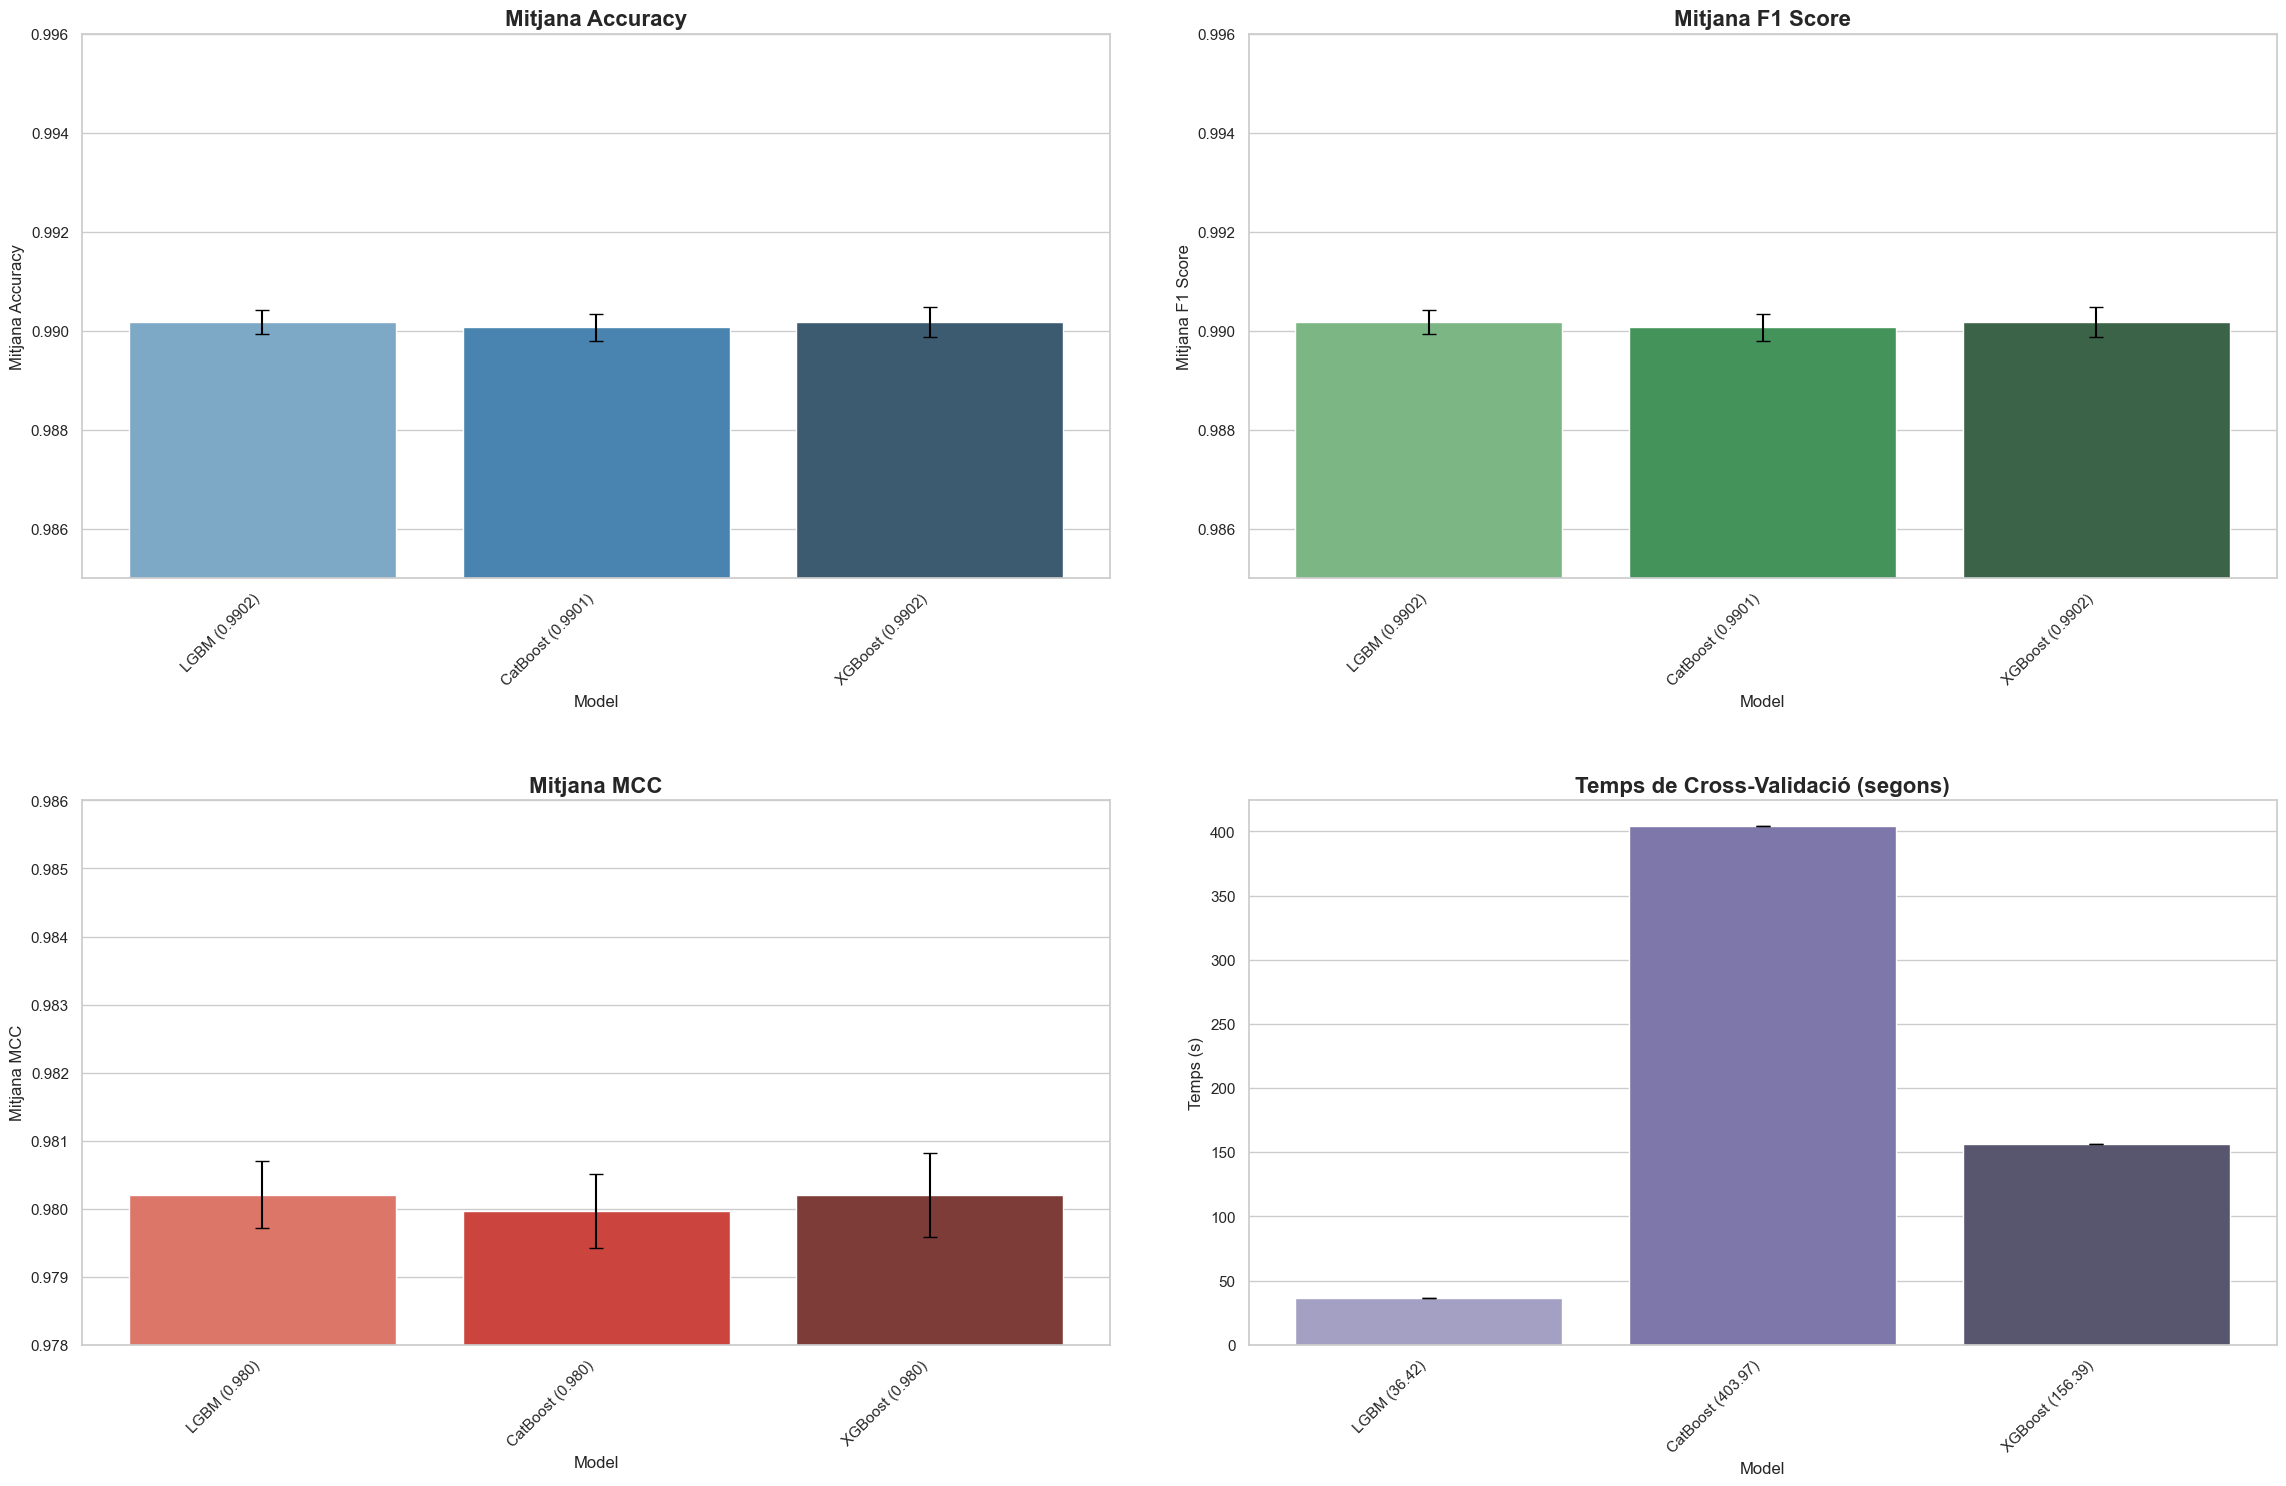

In [143]:
model1 = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.4, n_estimators=140, colsample_bytree=0.6, reg_lambda=50, min_child_samples=20, num_leaves=235, max_depth=15)
model2 = CatBoostClassifier(
    iterations=300,        
    depth=15,              
    learning_rate=0.1,       
    loss_function='Logloss',
    eval_metric='Accuracy',   
    early_stopping_rounds=50, 
    verbose= False,
    task_type="GPU",
    devices='0',
    l2_leaf_reg=0.5,
    bagging_temperature=0.6,
    border_count=72
)
model3 = XGBClassifier(
        tree_method="hist", 
        eval_metric="logloss", 
        device = "cuda",
        n_estimators=1600,
        max_depth=15,
        learning_rate=0.01,
        subsample=0.7,
        alpha=0.001
)
models = [model1, model2, model3]
#models = [model1]
model_names = ['LGBM', 'CatBoost', 'XGBoost']
#model_names = ['LGBM']

results = compare_models_cv(models, model_names, X_train, y_train, cv=5, verbose=True)

## Resultats sense emplenar NaNs

Com que els models que hem utilitzat tenen suport natiu per bases de dades amb NaNs hem provat de no fer un preprocessament dels nulls i hem obtingut millors resultats que no tractant-los, segurament això és degut a que utilitzem només la mitjana i la moda per emplenar i que hi han característiques amb un alt percentatge de nulls.


Evaluant model: LGBM
Fold 1: Accuracy = 0.9912, F1 Score = 0.9912, MCC = 0.9824
Fold 2: Accuracy = 0.9908, F1 Score = 0.9908, MCC = 0.9815
Fold 3: Accuracy = 0.9911, F1 Score = 0.9911, MCC = 0.9821
Fold 4: Accuracy = 0.9911, F1 Score = 0.9911, MCC = 0.9821
Fold 5: Accuracy = 0.9917, F1 Score = 0.9917, MCC = 0.9832

Accuracy: 0.9912 ± 0.0003
F1 Score: 0.9912 ± 0.0003
MCC: 0.9822 ± 0.0006

Evaluant model: CatBoost
Fold 1: Accuracy = 0.9904, F1 Score = 0.9904, MCC = 0.9807
Fold 2: Accuracy = 0.9905, F1 Score = 0.9905, MCC = 0.9809
Fold 3: Accuracy = 0.9905, F1 Score = 0.9905, MCC = 0.9809
Fold 4: Accuracy = 0.9906, F1 Score = 0.9906, MCC = 0.9810
Fold 5: Accuracy = 0.9912, F1 Score = 0.9912, MCC = 0.9822

Accuracy: 0.9907 ± 0.0003
F1 Score: 0.9907 ± 0.0003
MCC: 0.9811 ± 0.0005

Evaluant model: XGBoost
Fold 1: Accuracy = 0.9913, F1 Score = 0.9913, MCC = 0.9824
Fold 2: Accuracy = 0.9910, F1 Score = 0.9910, MCC = 0.9818
Fold 3: Accuracy = 0.9911, F1 Score = 0.9911, MCC = 0.9820
Fold 4: Accu

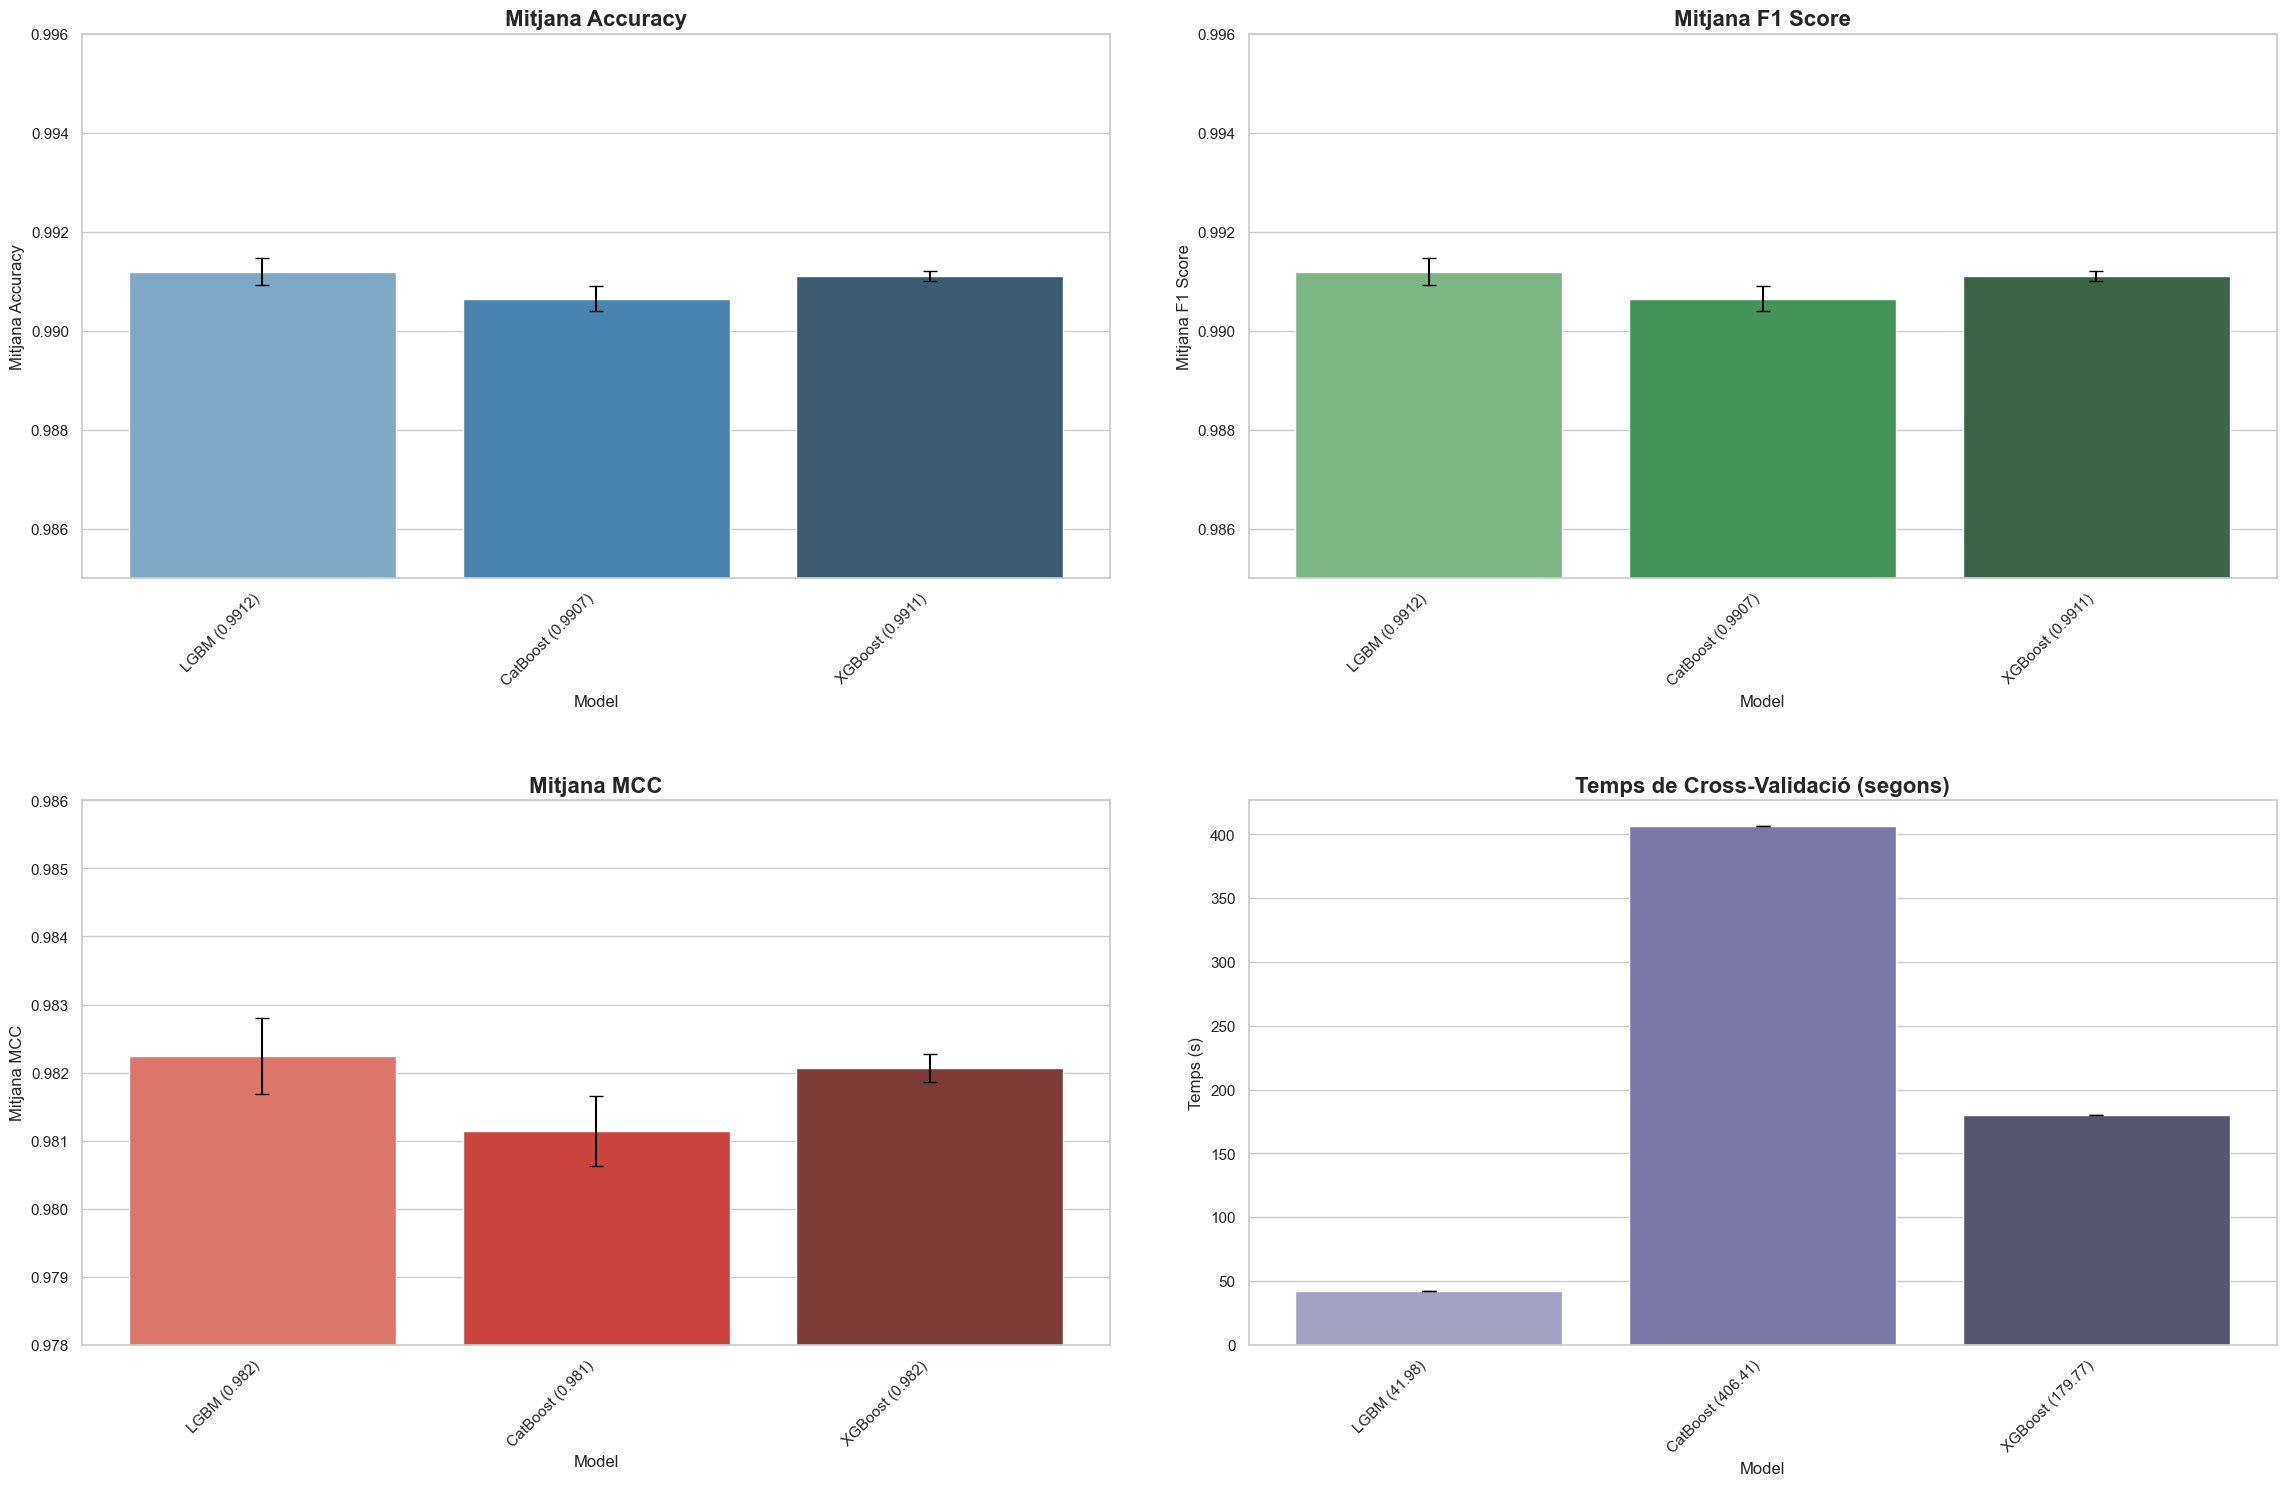

In [145]:
model1 = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.4, n_estimators=140, colsample_bytree=0.6, reg_lambda=50, min_child_samples=20, num_leaves=235, max_depth=15)
model2 = CatBoostClassifier(
    iterations=300,        
    depth=15,              
    learning_rate=0.1,       
    loss_function='Logloss',
    eval_metric='Accuracy',   
    early_stopping_rounds=50, 
    verbose= False,
    task_type="GPU",
    devices='0',
    l2_leaf_reg=0.5,
    bagging_temperature=0.6,
    border_count=72
)
model3 = XGBClassifier(
        tree_method="hist", 
        eval_metric="logloss", 
        device = "cuda",
        n_estimators=1600,
        max_depth=15,
        learning_rate=0.01,
        subsample=0.7,
        alpha=0.001
)
models = [model1, model2, model3]
model_names = ['LGBM', 'CatBoost', 'XGBoost']
#model_names = ['LGBM']

results = compare_models_cv(models, model_names, X_train, y_train, cv=5, verbose=True)

# Conclusions

En aquest treball hem utilitzat un dataset amb moltíssimes dades, per tant, hem hagut de tenir molt en compte el rendiment, per això ens hem decantat només per models que fan us de la targeta gràfica i com que tenim característiques desbalancejades ens hem centrat en models que funcionen bé en aquestes situacions com són els arbres potenciats de gradient.

Aquest dataset és una versió ampliada i amb un pitjor manteniment en comparació al proposat originalment en la llista de possibles casos Kaggle a fer. L'original no contenia valors nuls, no tenia tants atributs únics per a cada característica i tenia només 8124 entrades en comparació a les 3110694 d'aquest dataset.

També era un cas en què era molt fàcil obtenir un 100% d'accuracy, amb molts menys passos teníem un molt millor rendiment i millors resultats.

Vam decidir fer aquest canvi de dataset per poder aplicar millor totes les coses treballades a classe i plantejar-nos un major repte.

Al final tot i totes aquestes complicacions hem pogut obtenir uns resultats molt satisfactoris, dels models avaluats: LGBM, CatBoost i XGBoost, tots tres han obtingut resultats molt similars, amb un 99% d'accuracy i F1-score, i 0.982 de MCC score (mètrica utilitzada en el playground). Els models es diferencien pràcticament només en l'apartat de rendiment, on el model LGBM ha obtingut molts millors resultats, sent unes 12.2 vegades més ràpid que el model CatBoost i 4.6 vegades més ràpid que el XGBoost, manetenint i fins i tot millorant l'exactitud en les prediccions.

Per tant, el millor model que hem entrenat ha sigut el LGBM, amb un rendiment mitjà de 34.83 segons per 5 iteracions de validació creuada i un MCC mitjà del 98,2%.